<img src='logo.png'>

# Analise de Portfólio de Ações e Previsão com Séries Temporais

---

### VEJA ANÁLISE COMPLETA NO [PORTFÓLIO](https://sites.google.com/view/portflio-wiliams-alves/detalhes).

#### Problema de negócio:
 - O CEO gostaria de maximizar os resultados oferecendo um portfólio rentável a seus clientes, onde eles possam visualizar o desempenho da carteira de ações no período analisado e ter a possibilidade de fazer simulações de rendimentos, tanto para o passado quanto para o futuro, para isso o CEO nos deixou algumas perguntas, que foram:

1. Quais ações compõem o portfólio?
2. Qual a taxa de retorno, volatilidade e índice sharpe ratio do portfólio?
3. Quais os pesos de cada ação do portfólio?
4. Qual a simulação de rendimentos do portfólio dos últimos 5 anos com capital mínimo de 100,00?
5. Qual a simulação de rendimentos para os próximos 365 dias aplicando capital mínimo de 100,00?

Com base nas questões levantadas pelo CEO, realizaremos análise exploratória dos dados, levantamento e validação de hipóteses, previsões usando séries temporais e por fim o deploy da aplicação web, disponível clicando [**AQUI**](https://app-portfolio-analysis-and-forecasting-waxe5mykflzhg4jvw37ass.streamlit.app).
 
#### Análise Exploratória de Dados:
 - O critério de seleção das ações que irão compor o portfólio será análise técnica de gráfico, onde selecionaremos apenas as ações que estiverem em tendência de alta, ou seja, com o preço acima da linha de tendência de alta, após essa primeira seleção serão analisadas as ações que tenham correlação abaixo de 0.5, pois para ter um portfólio bem diversificado, temos que garantir que os ativos que o compõem tenham baixa correlação entre si.


#### As hipóteses levantadas durante análise exploratória são:
1. Quais ações estão em tendência de alta?
2. Existe ações com correlação menor ou igual a 0.5?
3. O portfólio mantém ações que obtiveram retornos positivos no período analisado?
4. Quais ativos apresentaram o maior e menor retorno?
5. Quais ativos apresentaram a maior e a menor volatilidade?
6. Obtivemos retorno de portfólio maior que o risco? Qual a fronteira de eficiência?
7. Quais os valores obtidos nos indicadores de Retorno Esperado, Volatilidade Esperada e Sharpe Ratio? 
8. Simulando o rendimento dos últimos 5 anos, podemos afirmar que o portfólio foi rentável no período da análise?
9. Quais empresas tiveram maior peso no portfólio?


#### Aplicação do algoritmo Prophet para previsão de Séries Temporais
 - O algoritmo usado para previsão das cotações das ações do portfólio é o `Prophet`, será usado para criar uma base de previsões futuras que possibilitará simulações de rendimentos de aplicações futuras. Saiba mais sobre o Prophet acessando o site https://pypi.org/project/prophet/.
 - A avaliação do modelo será com algoritmo `mean_absolute_error`, esta função da biblioteca `sckit-learn`, calcula o erro absoluto médio e irá nos informar qual a margem de erro das cotações do modelo criado.
 - Visualização dos gráficos e componentes da previsão, veremos a tendência, a sazonalidade anual e a sazonalidade semanal para cada série temporal, ou seja, para cada empresa.
 - Criação da base de previsão futuras consolidada com todas as séries temporais.
 - Análise financeira da base e análise dos indicadores.
 - Simulação de rendimentos sobre a base de previsão. 

---

In [1]:
import pandas as pd
from pandas.tseries.offsets import BDay
import datetime
import numpy as np
from bs4 import BeautifulSoup
import re
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import linregress
import sys
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import plotting
from pypfopt import cla
import six
sys.modules['sklearn.externals.six'] = six
import mlrose
from prophet import Prophet
from prophet.plot import plot_plotly
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Versão do Python
print('Versão do Python usada {}'.format(sys.version[0:6]))

Versão do Python usada 3.9.16


In [3]:
def extraction_list_b3(html):
    # Organizando e limpando tags html
    soup = BeautifulSoup(html, 'html.parser')
    data = soup.select('td')
    data = re.sub('<.*?>', '', str(data))
    data = data.strip('][').split(',')
    
    # Criando matriz
    matriz = []
    for i in range(0, len(data), 6):
        matriz.append(data[i:i+4])
    
    # Convertendo a matriz em um dataframe
    data = pd.DataFrame(matriz, columns=['Códigos', 'Ação', 'Tipo', 'Quantidade'])
    data = data[:-2]
    
    # Limpando espaço das celulas da coluna
    data['Códigos'] = data['Códigos'].str.strip()
   
    return data

In [4]:
def extraction_quotation(data, start_date='',end_date=''):
    # Extração dos tickers das ações
    tcks = []
    for i in data:
        tcks.append(i + '.SA')
        
    # Download cotações
    data = yf.download(tcks, start=start_date, end=end_date)['Adj Close']
    
    # Renomeando colunas
    data.columns = [re.sub(r'\.SA$', '', col) for col in data.columns]
       
    return data

In [5]:
def show_dimensions(data):
    print('Total Linhas: {}'.format(data.shape[0]))
    print('Total Colunas: {}'.format(data.shape[1]))
    return None

In [6]:
def null_treatment(data):
    # Verificando quais colunas tem valores NaN
    data_colunas_nan = data.columns[data.isna().any()].tolist()
    print('Colunas com valores NaN:',data_colunas_nan)
    print('Total de colunas alteradas:',len(data_colunas_nan))
    
    # Percorre cada coluna com valores NaN substitui os valores NaN pelo primeiro valor diferente encontrado
    for i in data_colunas_nan:
        primeiro_nao_nan = data[i].dropna().iloc[0]
        data[i].fillna(primeiro_nao_nan, inplace=True)
        
    return data

In [7]:
def trend_analysis(data, bias=''):
    # Criando copia da base
    dataset = data.copy()
    
    # Analisando a tendencia
    codigo = dataset.columns
    trend = []
    for i in range(len(dataset.columns)):
        slope, intercept, rvalue, pvalue, stderr = linregress(range(len(dataset)), dataset.iloc[:,i])
        trendline = intercept + slope * range(len(dataset))
        trendline = pd.DataFrame(trendline)

         # Condição da avaliação
        if (dataset.iloc[-1,i] > trendline.iloc[-1,0]) & (trendline.iloc[-1,0] > trendline.iloc[0,0]):
            trend.append('ALTA')
        else:
            trend.append('BAIXA')

    avaliacao = pd.DataFrame(data = {'Código':codigo, 'Tendência':trend})
    tendencia_alta = avaliacao.loc[avaliacao['Tendência'] == bias]
    dataset = dataset[tendencia_alta['Código']]

    return tendencia_alta, dataset

In [121]:
def analysis_chart(data, figsize):
    fig, axs = plt.subplots(5, 3, figsize=figsize, sharex=True)
    axs = axs.flatten()
    for i in range(len(data.columns)):
        slope, intercept, rvalue, pvalue, stderr = linregress(range(len(data)), data.iloc[:,i])
        trendline = intercept + slope * range(len(data))
        trendline = pd.DataFrame(trendline, index=data.index)
        
        axs[i].plot(data.index, data.iloc[:,i])
        axs[i].plot(data.index, trendline, 'r')
        axs[i].set_title('Gráfico de tendência da ação {}'.format(data.columns[i]))
        
        axs[i].tick_params(axis='x', rotation=45)
        axs[i].margins(x=0)
        axs[i].grid(True)
        
    plt.tight_layout()
    plt.show()
    
    return None

In [9]:
def analyze_correlation_limit(data, correlation_limit):
    # Calculando a taxa de retorno diária
    taxa_retorno = data.pct_change()
    # Criando matriz de correlação
    matrix_corr = taxa_retorno.corr()
    # Definindo limite de correlação
    corr_limit = correlation_limit
    # Filtrando ações
    acoes_selecionadas = list(data.columns)
    for i, acao in enumerate(data.columns):
        if acao in acoes_selecionadas:
            correlacoes = matriz_corr.iloc[i, :]
            for j, corr in enumerate(correlacoes):
                if corr >= corr_limit and j != i and data.columns[j] in acoes_selecionadas:
                    acoes_selecionadas.remove(data.columns[j])
    # Selecionando ações
    acoes_selecionadas = data[acoes_selecionadas]
    
    return acoes_selecionadas

In [10]:
def analyze_correlation(data):
    # Calculando a taxa de retorno diária
    taxa_retorno = data.pct_change()
    # Criando matriz de correlação
    matrix_corr = taxa_retorno.corr()
    
    return matrix_corr

In [11]:
def heatmap_corr(matrix_corr, size):
    plt.figure(figsize=size)
    sns.heatmap(matrix_corr, annot=True);
    
    return None

In [12]:
def analysis_finance(data):
    # Taxa de retorno diário
    retorno_diario = data.pct_change().fillna(0)
    
    # Normalização dos preços das ações, retorno diario na escala logaritimica
    retorno_log = expected_returns.prices_from_returns(expected_returns.returns_from_prices(data, log_returns=True))
    
    # Taxa de retorno anualizada
    retorno_anual = expected_returns.mean_historical_return(prices=data, compounding=False, frequency=252)
    
    # Matriz de covariância
    matriz_cov = risk_models.risk_matrix(data, method='sample_cov')
    
    return retorno_diario, retorno_log, retorno_anual, matriz_cov

In [13]:
def portfolio_optimization(data):
    # Função fitness
    def sharpe_ratio(solucao):
        # Criando copia da base
        dataset = data.copy()
        # Normalizando os pesos
        pesos = solucao / solucao.sum()
        # Calculo do retorno medio
        returns = dataset.pct_change().mean() * 252
        # Calculo do retorno do portfolio
        portfolio_return = np.dot(returns, pesos)
        # Matriz de covariancia do portfolio
        cov_matrix = dataset.pct_change().cov()
        # Risco do portfolio
        portfolio_std_dev = np.sqrt(np.dot(pesos.T, np.dot(cov_matrix * 252, pesos)))
        # Taxa selic do período
        risk_free = np.array([6.43, 5.77, 2.55, 5.02, 12.83]).mean() / 100
        # Calculo do indice sharpe
        sharpe_ratio = np.around((portfolio_return - risk_free) / portfolio_std_dev,3)
        return sharpe_ratio
    
    # Função perosonalizada
    fitness = mlrose.CustomFitness(sharpe_ratio)
    # Definindo problema de maximização
    problema_maximizacao = mlrose.ContinuousOpt(length=len(data.columns),
                                                    fitness_fn=fitness,
                                                    maximize=True, 
                                                    min_val=0,
                                                    max_val= 1)
    # Executando o modelo
    melhor_solucao, melhor_custo = mlrose.genetic_alg(problema_maximizacao,
                                                      random_state=1)
    # Normalizando a melhor solucao de distribuição dos pesos
    melhor_solucao = melhor_solucao / melhor_solucao.sum()
    # Distribuição dos pesos por ação
    acoes_pesos = data.columns
    acoes_pesos = pd.DataFrame(data = {'Ações':acoes_pesos, 'Pesos':melhor_solucao})
    
    return melhor_solucao, melhor_custo, acoes_pesos

In [14]:
def return_volatlity(data, pesos):
    # Criando copia da base
    dataset = data.copy()
    
    # Taxa de retorno diario
    tx_retorno = dataset.pct_change().fillna(0)
    
    # Taxa de retorno anualizada
    retorno = np.around((np.sum(tx_retorno.mean() * pesos) * 252) * 100, 2)
    print('Retorno esperado: {}%'.format(retorno))
    
    # Calculo da volatilidade
    volatilidade = np.around((np.sqrt(np.dot(pesos, np.dot(tx_retorno.cov() * 252, pesos)))) * 100, 2)
    print('Volatilidade esperada: {}%'.format(volatilidade))
    
    return None

In [15]:
def chart_return_daily(return_daily):
    figura = px.line(title='Gráfico de retorno diário das ações')
    for i in return_daily.columns:
        figura.add_scatter(x = return_daily.index, y = return_daily[i], name = i)
    figura.show("png")

    return None

In [16]:
def chart_return_log(return_log):
    figura = px.line(title='Gráfico crescimento das ações')
    for i in return_log.columns:
        figura.add_scatter(x = return_log.index, y = return_log[i], name = i)
    figura.show("png")
    
    return None

In [17]:
def covariance_map(matrix_cov):
    plt.figure(figsize=(10,10))
    plotting.plot_covariance(matrix_cov);
    
    return None

In [18]:
def chart_efficient_frontier(return_daily, matrix_cov):
    fronteira_eficiente = cla.CLA(return_daily, matrix_cov)
    plt.figure(figsize=(8,4))
    plotting.plot_efficient_frontier(fronteira_eficiente);
    
    return None

In [19]:
def income_simulation(data, pesos, capital):
    # Criando copia da base
    data_original = data.copy()
    
    # Normalizando a base
    data_original = data_original / data_original.iloc[0]
    
    # Obtendo o rendimentos por ação e por dia
    for i, j in enumerate(data_original.columns):
        data_original[j] = data_original[j] * pesos[i] * capital
    
    # Agrupando em uma coluna
    data_original['Rendimentos'] = data_original.sum(axis=1, numeric_only=True)
    
    # Criando coluna e calculando a Taxa de retorno
    data_original['Taxa_Retorno'] = 0.0
    for i in range(1, len(data_original)):
        data_original['Taxa_Retorno'][i] = ((data_original['Rendimentos'][i] / data_original['Rendimentos'][i - 1]) - 1) * 100
    
    # Retorno em reais
    rendimento = np.around(data_original['Rendimentos'][-1] - data_original['Rendimentos'][0], 2) 
    print('Rendimento sobre capital investido: R$ {}'.format(rendimento))
    
    # Retorno do investimento
    roi = np.around(((data_original['Rendimentos'][-1] - data_original['Rendimentos'][0]) / data_original['Rendimentos'][0]) * 100, 3)
    print('Retorno total do portfólio: {}%'.format(roi))
    
    # Gráfico da taxa de retorno diário
    grafico_retorno_diario = px.line(data_original, x = data_original.index, y = data_original['Taxa_Retorno'],
                                     title = 'Taxa de retorno diário do Portfólio')
    grafico_retorno_diario.show("png")
    
    # Gráfico de rendimentos do portfólio
    grafico_rendimentos = px.line(data_original, x = data_original.index, y = data_original['Rendimentos'], 
                                  title = 'Redimentos do Portfólio')
    grafico_rendimentos.show("png")
    
    
    return data_original 

In [20]:
def model_time_series(data, tick, n_forecast):
    # Criando copia da base de dados
    dataset = data.copy()
    
    # Selecionando os dados da base
    dataset = dataset[['Date', tick]]
    
    # Renomando colunas para o padrão do algoritimo
    dataset.columns = ['ds', 'y']
    
    # Criando base de teste e treino
    base_treino = dataset[:len(dataset)-n_forecast]
    base_teste = dataset[len(dataset)-n_forecast:]
    
    # Criando, treinando e fazendo as previsões
    model = Prophet(growth='linear',
                changepoints=None,
                changepoint_prior_scale=0.05,
                seasonality_mode='additive',
                seasonality_prior_scale=10.0,
                interval_width=0.8)
    model.fit(base_treino)
    future = model.make_future_dataframe(periods=n_forecast)
    forecast = model.predict(future)
    
    # Criando base de previsões
    forecast_test = forecast[['ds', 'yhat']].tail(n_forecast)
    forecast_test.columns = ['Date', tick]
    
    return base_teste, model, forecast, forecast_test

In [21]:
def mean_error_model_time_series(base_teste, data_forecast):
    error = np.around(mean_absolute_error(base_teste.iloc[:,1], data_forecast.iloc[:,1]), 2)
    print('A margem de erro médio da previsão de preços da ação {} é de R$ {}'.format(data_forecast.columns[1], error))
    return None

In [22]:
def price_forecast(data, tick, n_forecast):
    # Criando copia da base de dados
    dataset = data.copy()
    
    # Selecionando os dados da base
    dataset = dataset[['Date', tick]]
    
    # Renomando colunas para o padrão do algoritimo
    dataset.columns = ['ds', 'y']
    
    # Criando, treinando e fazendo as previsões
    model = Prophet(growth='linear',
                changepoints=None,
                changepoint_prior_scale=0.05,
                seasonality_mode='additive',
                seasonality_prior_scale=10.0,
                interval_width=0.8)
    model.fit(dataset)
    future = model.make_future_dataframe(periods=n_forecast)
    forecast = model.predict(future)
    
    # Criando base de previsões
    forecast_test = forecast['yhat'].tail(n_forecast)
    
    return forecast_test

In [99]:
def forecast_data(data, date_inicial,n_forecast):
    # Definir a data de início e fim
    date_inicio = date_inicial
    dias = n_forecast
    
    # Obter a data atual e adicionar a quantidade de dias
    date_fim = datetime.date.today() + datetime.timedelta(days=dias)
    
    # Gerar um intervalo de datas
    intervalo_dates = pd.date_range(start=date_inicio, end=date_fim)

    # Filtrar apenas as datas úteis
    dates_uteis = pd.bdate_range(start=date_inicio, end=date_fim, freq=BDay())

    # Criar um DataFrame com as datas úteis
    dates = pd.DataFrame({'data': dates_uteis})   
    
    # Base de previsões e consolidada
    previsao_acoes = pd.DataFrame(columns=['Date'] + list(data.columns[1:]))
    for i in data.columns[1:]:
        d = price_forecast(data, i, len(dates))
        previsao_acoes['Date'] = dates['data']
        previsao_acoes[i] = d.values
        
    return previsao_acoes

In [24]:
def indication_forecast(data, pesos):
    # Criando copia da base
    dataset = data.copy()
    
    # Taxa de retorno diario
    tx_retorno = dataset.pct_change().fillna(0)
    
    # Taxa de retorno anualizada
    retorno = np.around((np.sum(tx_retorno.mean() * pesos) * 252) * 100, 2)
    print('Retorno esperado: {}%'.format(retorno))
    
    # Calculo da volatilidade
    volatilidade = np.around((np.sqrt(np.dot(pesos, np.dot(tx_retorno.cov() * 252, pesos)))) * 100, 2)
    print('Volatilidade esperada: {}%'.format(volatilidade))
    
    # Sharpe ratio
    sharpe = np.round(retorno / volatilidade,3)
    print('Sharpe Ratio: {}'.format(sharpe))
    
    return None

In [25]:
def chart_forecast(model, forecast, tick):
    figure = plot_plotly(model, forecast)
    figure.update_layout(title_text='Gráfico de previsão do preço da ação {}'.format(tick))
    figure.show("png")
    
    return None

In [26]:
def chart_price_portfolio(data):
    data.plot(x = 'Date', figsize=(15,7), title='Histórico do preço das ações');
    return None

In [27]:
def chart_histogram_frequency(data):
    plt.figure(figsize=(20,30))
    for i in np.arange(1, len(data.columns)):
        plt.subplot(5, 4, i)
        sns.histplot(data[data.columns[i]], kde=True)
        plt.title(data.columns[i])
    return None

In [28]:
def chart_boxplot_frequency(data):
    plt.figure(figsize=(20,25))
    for i in np.arange(1, len(df.columns)):
        plt.subplot(5, 4, i)
        sns.boxplot(x=df[df.columns[i]])
        plt.title(df.columns[i]);
        
    return None

## Extração das ações e cotações

### Lista das ações do índice Bovespa

Lista de ações que compõem o índice no site [B3.com](https://www.b3.com.br/pt_br/market-data-e-indices/indices/indices-amplos/indice-ibovespa-ibovespa-composicao-da-carteira.htm), lista atualizada em 31/03/2023.

In [29]:
# Link html
html = """<table class="table table-responsive-sm table-responsive-md"><thead><tr><th>Código</th><th>Ação</th><th>Tipo</th><th>Qtde. Teórica</th><th>Part. (%)</th></tr></thead><tbody><tr><td>RRRP3</td><td>3R PETROLEUM</td><td>ON  ATZ NM</td><td class="text-right">196.144.421</td><td class="text-right">0,292</td></tr><tr><td>ALSO3</td><td>ALIANSCSONAE</td><td>ON      NM</td><td class="text-right">330.109.863</td><td class="text-right">0,327</td></tr><tr><td>ALPA4</td><td>ALPARGATAS</td><td>PN      N1</td><td class="text-right">202.765.994</td><td class="text-right">0,081</td></tr><tr><td>ABEV3</td><td>AMBEV S/A</td><td>ON</td><td class="text-right">4.386.652.506</td><td class="text-right">3,473</td></tr><tr><td>ARZZ3</td><td>AREZZO CO</td><td>ON      NM</td><td class="text-right">60.758.326</td><td class="text-right">0,221</td></tr><tr><td>ASAI3</td><td>ASSAI</td><td>ON      NM</td><td class="text-right">1.189.793.199</td><td class="text-right">0,847</td></tr><tr><td>AZUL4</td><td>AZUL</td><td>PN      N2</td><td class="text-right">327.646.296</td><td class="text-right">0,200</td></tr><tr><td>B3SA3</td><td>B3</td><td>ON      NM</td><td class="text-right">5.901.731.302</td><td class="text-right">3,808</td></tr><tr><td>BPAN4</td><td>BANCO PAN</td><td>PN      N1</td><td class="text-right">341.549.703</td><td class="text-right">0,101</td></tr><tr><td>BBSE3</td><td>BBSEGURIDADE</td><td>ON      NM</td><td class="text-right">671.682.536</td><td class="text-right">1,247</td></tr><tr><td>BBDC3</td><td>BRADESCO</td><td>ON      N1</td><td class="text-right">1.508.883.586</td><td class="text-right">1,003</td></tr><tr><td>BBDC4</td><td>BRADESCO</td><td>PN      N1</td><td class="text-right">5.156.077.326</td><td class="text-right">3,800</td></tr><tr><td>BRAP4</td><td>BRADESPAR</td><td>PN      N1</td><td class="text-right">251.016.648</td><td class="text-right">0,355</td></tr><tr><td>BBAS3</td><td>BRASIL</td><td>ON      NM</td><td class="text-right">1.420.731.069</td><td class="text-right">3,319</td></tr><tr><td>BRKM5</td><td>BRASKEM</td><td>PNA     N1</td><td class="text-right">265.212.486</td><td class="text-right">0,290</td></tr><tr><td>BRFS3</td><td>BRF SA</td><td>ON      NM</td><td class="text-right">1.076.512.610</td><td class="text-right">0,358</td></tr><tr><td>BPAC11</td><td>BTGP BANCO</td><td>UNT     N2</td><td class="text-right">1.225.470.424</td><td class="text-right">1,500</td></tr><tr><td>CRFB3</td><td>CARREFOUR BR</td><td>ON  ED  NM</td><td class="text-right">528.743.156</td><td class="text-right">0,314</td></tr><tr><td>CCRO3</td><td>CCR SA</td><td>ON      NM</td><td class="text-right">998.462.635</td><td class="text-right">0,701</td></tr><tr><td>CMIG4</td><td>CEMIG</td><td>PN      N1</td><td class="text-right">1.442.098.974</td><td class="text-right">0,962</td></tr><tr><td>CIEL3</td><td>CIELO</td><td>ON      NM</td><td class="text-right">1.095.401.258</td><td class="text-right">0,300</td></tr><tr><td>COGN3</td><td>COGNA ON</td><td>ON      NM</td><td class="text-right">1.820.405.422</td><td class="text-right">0,199</td></tr><tr><td>CPLE6</td><td>COPEL</td><td>PNB     N2</td><td class="text-right">1.563.365.506</td><td class="text-right">0,651</td></tr><tr><td>CSAN3</td><td>COSAN</td><td>ON      NM</td><td class="text-right">1.171.063.698</td><td class="text-right">0,992</td></tr><tr><td>CPFE3</td><td>CPFL ENERGIA</td><td>ON      NM</td><td class="text-right">187.732.538</td><td class="text-right">0,336</td></tr><tr><td>CMIN3</td><td>CSNMINERACAO</td><td>ON      N2</td><td class="text-right">1.110.550.596</td><td class="text-right">0,280</td></tr><tr><td>CVCB3</td><td>CVC BRASIL</td><td>ON      NM</td><td class="text-right">275.967.676</td><td class="text-right">0,049</td></tr><tr><td>CYRE3</td><td>CYRELA REALT</td><td>ON      NM</td><td class="text-right">274.142.301</td><td class="text-right">0,230</td></tr><tr><td>DXCO3</td><td>DEXCO</td><td>ON      NM</td><td class="text-right">274.863.424</td><td class="text-right">0,090</td></tr><tr><td>ECOR3</td><td>ECORODOVIAS</td><td>ON      NM</td><td class="text-right">310.103.685</td><td class="text-right">0,103</td></tr><tr><td>ELET3</td><td>ELETROBRAS</td><td>ON      N1</td><td class="text-right">1.871.213.500</td><td class="text-right">3,379</td></tr><tr><td>ELET6</td><td>ELETROBRAS</td><td>PNB     N1</td><td class="text-right">275.526.814</td><td class="text-right">0,554</td></tr><tr><td>EMBR3</td><td>EMBRAER</td><td>ON      NM</td><td class="text-right">734.632.205</td><td class="text-right">0,806</td></tr><tr><td>ENBR3</td><td>ENERGIAS BR</td><td>ON  ED  NM</td><td class="text-right">246.028.184</td><td class="text-right">0,296</td></tr><tr><td>ENGI11</td><td>ENERGISA</td><td>UNT     N2</td><td class="text-right">248.477.689</td><td class="text-right">0,579</td></tr><tr><td>ENEV3</td><td>ENEVA</td><td>ON      NM</td><td class="text-right">1.576.898.490</td><td class="text-right">0,958</td></tr><tr><td>EGIE3</td><td>ENGIE BRASIL</td><td>ON      NM</td><td class="text-right">255.208.461</td><td class="text-right">0,564</td></tr><tr><td>EQTL3</td><td>EQUATORIAL</td><td>ON      NM</td><td class="text-right">1.100.513.485</td><td class="text-right">1,680</td></tr><tr><td>EZTC3</td><td>EZTEC</td><td>ON      NM</td><td class="text-right">94.318.339</td><td class="text-right">0,076</td></tr><tr><td>FLRY3</td><td>FLEURY</td><td>ON      NM</td><td class="text-right">351.919.239</td><td class="text-right">0,275</td></tr><tr><td>GGBR4</td><td>GERDAU</td><td>PN      N1</td><td class="text-right">1.147.768.260</td><td class="text-right">1,602</td></tr><tr><td>GOAU4</td><td>GERDAU MET</td><td>PN      N1</td><td class="text-right">667.194.478</td><td class="text-right">0,434</td></tr><tr><td>GOLL4</td><td>GOL</td><td>PN      N2</td><td class="text-right">190.059.275</td><td class="text-right">0,071</td></tr><tr><td>NTCO3</td><td>GRUPO NATURA</td><td>ON      NM</td><td class="text-right">835.961.011</td><td class="text-right">0,503</td></tr><tr><td>SOMA3</td><td>GRUPO SOMA</td><td>ON      NM</td><td class="text-right">490.736.222</td><td class="text-right">0,213</td></tr><tr><td>HAPV3</td><td>HAPVIDA</td><td>ON      NM</td><td class="text-right">4.455.957.762</td><td class="text-right">0,607</td></tr><tr><td>HYPE3</td><td>HYPERA</td><td>ON      NM</td><td class="text-right">400.842.480</td><td class="text-right">0,814</td></tr><tr><td>IGTI11</td><td>IGUATEMI S.A</td><td>UNT     N1</td><td class="text-right">213.576.831</td><td class="text-right">0,231</td></tr><tr><td>ITSA4</td><td>ITAUSA</td><td>PN      N1</td><td class="text-right">5.233.076.295</td><td class="text-right">2,424</td></tr><tr><td>ITUB4</td><td>ITAUUNIBANCO</td><td>PN      N1</td><td class="text-right">4.801.489.940</td><td class="text-right">6,690</td></tr><tr><td>JBSS3</td><td>JBS</td><td>ON      NM</td><td class="text-right">1.134.986.483</td><td class="text-right">1,038</td></tr><tr><td>KLBN11</td><td>KLABIN S/A</td><td>UNT     N2</td><td class="text-right">701.899.756</td><td class="text-right">0,701</td></tr><tr><td>RENT3</td><td>LOCALIZA</td><td>ON      NM</td><td class="text-right">776.996.207</td><td class="text-right">2,414</td></tr><tr><td>LWSA3</td><td>LOCAWEB</td><td>ON      NM</td><td class="text-right">419.466.860</td><td class="text-right">0,127</td></tr><tr><td>LREN3</td><td>LOJAS RENNER</td><td>ON      NM</td><td class="text-right">965.528.807</td><td class="text-right">0,868</td></tr><tr><td>MGLU3</td><td>MAGAZ LUIZA</td><td>ON      NM</td><td class="text-right">2.874.188.573</td><td class="text-right">0,565</td></tr><tr><td>MRFG3</td><td>MARFRIG</td><td>ON      NM</td><td class="text-right">316.724.584</td><td class="text-right">0,106</td></tr><tr><td>CASH3</td><td>MELIUZ</td><td>ON      NM</td><td class="text-right">657.970.941</td><td class="text-right">0,033</td></tr><tr><td>BEEF3</td><td>MINERVA</td><td>ON      NM</td><td class="text-right">260.340.982</td><td class="text-right">0,131</td></tr><tr><td>MRVE3</td><td>MRV</td><td>ON      NM</td><td class="text-right">305.668.749</td><td class="text-right">0,120</td></tr><tr><td>MULT3</td><td>MULTIPLAN</td><td>ON      N2</td><td class="text-right">268.145.328</td><td class="text-right">0,374</td></tr><tr><td>PCAR3</td><td>P.ACUCAR-CBD</td><td>ON      NM</td><td class="text-right">157.889.627</td><td class="text-right">0,126</td></tr><tr><td>PETR3</td><td>PETROBRAS</td><td>ON      N2</td><td class="text-right">3.484.913.747</td><td class="text-right">5,600</td></tr><tr><td>PETR4</td><td>PETROBRAS</td><td>PN      N2</td><td class="text-right">4.566.441.248</td><td class="text-right">6,547</td></tr><tr><td>PRIO3</td><td>PETRORIO</td><td>ON      NM</td><td class="text-right">839.159.130</td><td class="text-right">1,628</td></tr><tr><td>PETZ3</td><td>PETZ</td><td>ON      NM</td><td class="text-right">335.724.569</td><td class="text-right">0,108</td></tr><tr><td>QUAL3</td><td>QUALICORP</td><td>ON      NM</td><td class="text-right">277.226.847</td><td class="text-right">0,060</td></tr><tr><td>RADL3</td><td>RAIADROGASIL</td><td>ON      NM</td><td class="text-right">1.196.069.386</td><td class="text-right">1,655</td></tr><tr><td>RAIZ4</td><td>RAIZEN</td><td>PN      N2</td><td class="text-right">1.200.488.532</td><td class="text-right">0,201</td></tr><tr><td>RDOR3</td><td>REDE D OR</td><td>ON      NM</td><td class="text-right">1.149.694.340</td><td class="text-right">1,358</td></tr><tr><td>RAIL3</td><td>RUMO S.A.</td><td>ON      NM</td><td class="text-right">1.215.642.613</td><td class="text-right">1,285</td></tr><tr><td>SBSP3</td><td>SABESP</td><td>ON      NM</td><td class="text-right">340.002.999</td><td class="text-right">0,893</td></tr><tr><td>SANB11</td><td>SANTANDER BR</td><td>UNT</td><td class="text-right">355.642.848</td><td class="text-right">0,526</td></tr><tr><td>SMTO3</td><td>SAO MARTINHO</td><td>ON      NM</td><td class="text-right">143.294.210</td><td class="text-right">0,216</td></tr><tr><td>CSNA3</td><td>SID NACIONAL</td><td>ON</td><td class="text-right">589.695.175</td><td class="text-right">0,465</td></tr><tr><td>SLCE3</td><td>SLC AGRICOLA</td><td>ON      NM</td><td class="text-right">96.272.020</td><td class="text-right">0,235</td></tr><tr><td>SUZB3</td><td>SUZANO S.A.</td><td>ON      NM</td><td class="text-right">726.823.001</td><td class="text-right">1,579</td></tr><tr><td>TAEE11</td><td>TAESA</td><td>UNT     N2</td><td class="text-right">218.568.234</td><td class="text-right">0,415</td></tr><tr><td>VIVT3</td><td>TELEF BRASIL</td><td>ON  ED</td><td class="text-right">423.091.712</td><td class="text-right">0,928</td></tr><tr><td>TIMS3</td><td>TIM</td><td>ON  ED  NM</td><td class="text-right">808.436.195</td><td class="text-right">0,597</td></tr><tr><td>TOTS3</td><td>TOTVS</td><td>ON      NM</td><td class="text-right">520.749.110</td><td class="text-right">0,758</td></tr><tr><td>UGPA3</td><td>ULTRAPAR</td><td>ON      NM</td><td class="text-right">1.087.887.681</td><td class="text-right">0,844</td></tr><tr><td>USIM5</td><td>USIMINAS</td><td>PNA     N1</td><td class="text-right">515.014.562</td><td class="text-right">0,208</td></tr><tr><td>VALE3</td><td>VALE</td><td>ON      NM</td><td class="text-right">3.394.804.584</td><td class="text-right">14,189</td></tr><tr><td>VIIA3</td><td>VIA</td><td>ON      NM</td><td class="text-right">1.576.975.642</td><td class="text-right">0,167</td></tr><tr><td>VBBR3</td><td>VIBRA</td><td>ON      NM</td><td class="text-right">1.114.442.976</td><td class="text-right">0,826</td></tr><tr><td>WEGE3</td><td>WEG</td><td>ON      NM</td><td class="text-right">1.318.583.017</td><td class="text-right">2,794</td></tr><tr><td>YDUQ3</td><td>YDUQS PART</td><td>ON      NM</td><td class="text-right">296.015.511</td><td class="text-right">0,130</td></tr><!----></tbody><tfoot><tr><td colspan="3"> Quantidade Teórica Total </td><td class="text-right">97.388.504.910</td><td class="text-right">100,000</td></tr><tr><td colspan="3"> Redutor </td><td class="text-right">17.573.981,14796004</td><td></td></tr></tfoot><!----></table>"""

In [30]:
# Obtendo relação de ações do índice com o código, ação, tipo e quantidade 
acoes_b3 = extraction_list_b3(html)
acoes_b3.head(10)

,Códigos,Ação,Tipo,Quantidade
0,RRRP3,3R PETROLEUM,ON ATZ NM,196.144.421
1,ALSO3,ALIANSCSONAE,ON NM,330.109.863
2,ALPA4,ALPARGATAS,PN N1,202.765.994
3,ABEV3,AMBEV S/A,ON,4.386.652.506
4,ARZZ3,AREZZO CO,ON NM,60.758.326
5,ASAI3,ASSAI,ON NM,1.189.793.199
6,AZUL4,AZUL,PN N2,327.646.296
7,B3SA3,B3,ON NM,5.901.731.302
8,BPAN4,BANCO PAN,PN N1,341.549.703
9,BBSE3,BBSEGURIDADE,ON NM,671.682.536


In [31]:
# Dimensões da base de dados das ações
show_dimensions(acoes_b3)

Total Linhas: 88
Total Colunas: 4


### Quotações das ações

Cotações extraidas usando API [yfinance](https://pypi.org/project/yfinance/).

In [32]:
# Dados para extração das cotações
acoes = acoes_b3['Códigos']
start_date = '2018-01-01'
end_date = '2023-03-31'

In [33]:
# Extraindo cotações das ações
data = extraction_quotation(acoes, start_date, end_date)
data.head(10)

[*********************100%***********************]  88 of 88 completed


,ABEV3,ALPA4,ALSO3,ARZZ3,ASAI3,AZUL4,B3SA3,BBAS3,BBDC3,BBDC4,...,TIMS3,TOTS3,UGPA3,USIM5,VALE3,VBBR3,VIIA3,VIVT3,WEGE3,YDUQ3
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,18.143393,13.472865,22.854151,51.007965,NaN,27.150000,6.272575,23.987268,14.492247,15.289302,...,10.777552,9.568254,34.739548,7.781023,28.455341,NaN,7.698611,27.304152,8.906308,29.762487
2018-01-03,18.185217,13.143698,23.027565,52.548176,NaN,27.059999,6.379354,24.293205,14.553893,15.359591,...,10.785718,9.771362,34.396523,8.040389,28.284828,NaN,7.738552,26.512726,8.771041,29.788851
2018-01-04,18.084839,13.128389,22.972803,54.206154,NaN,27.230000,6.420423,24.526304,14.818914,15.611597,...,10.736730,9.711065,34.798214,8.494284,28.400774,NaN,7.798464,26.802923,8.685610,29.665829
2018-01-05,18.151758,13.358040,23.000187,52.385086,NaN,27.200001,6.513514,24.526304,14.823411,15.700033,...,10.826540,9.920520,34.870426,8.129547,28.844110,NaN,7.548833,26.868881,8.721205,29.261610
2018-01-08,18.118299,13.090113,22.361290,51.741837,NaN,26.910000,6.543630,24.584574,14.823411,15.695611,...,10.679573,9.914173,35.114155,8.218705,29.485243,NaN,7.678641,27.152462,8.792399,29.367060
2018-01-09,18.068108,13.181973,22.133114,51.415665,NaN,26.799999,6.450539,24.351480,14.711109,15.549701,...,10.695905,9.917344,34.978756,8.307861,29.376112,NaN,7.718582,27.079916,8.934789,28.866188
2018-01-10,18.068108,12.822186,21.859303,51.460960,NaN,26.450001,6.393044,24.249504,14.616780,15.386117,...,10.442796,9.891958,34.707954,8.307861,28.966881,NaN,7.518878,26.736973,8.863592,28.892551
2018-01-11,18.277231,12.806875,21.904938,52.095169,NaN,26.549999,6.497085,24.803108,14.823411,15.695611,...,10.483620,9.879263,34.843357,8.753652,29.532986,NaN,7.738552,27.811989,9.034457,29.780062
2018-01-12,18.068108,13.097769,21.904938,51.279774,NaN,26.400000,6.464230,24.861385,14.823411,15.695611,...,10.516279,9.863396,34.920071,8.931966,29.703499,NaN,7.738552,27.561373,9.102091,28.997995


In [34]:
# Dimensões da base de dados
show_dimensions(data)

Total Linhas: 1301
Total Colunas: 88


### Limpeza dos dados

In [35]:
# Verificando quais colunas tem valores NaN e tratando os valores ausentes
data = null_treatment(data)

Colunas com valores NaN: ['ASAI3', 'BPAC11', 'CASH3', 'CMIN3', 'ENGI11', 'HAPV3', 'IGTI11', 'KLBN11', 'LWSA3', 'NTCO3', 'PETZ3', 'RAIZ4', 'RDOR3', 'RRRP3', 'SANB11', 'SOMA3', 'TAEE11', 'VBBR3']
Total de colunas alteradas: 18


In [36]:
# Verificando existencia de valores NaN
data.isnull().sum().sort_values(ascending=False)

ABEV3    0
ALPA4    0
QUAL3    0
PRIO3    0
PETZ3    0
        ..
CSNA3    0
CSAN3    0
CRFB3    0
CPLE6    0
YDUQ3    0
Length: 88, dtype: int64

In [37]:
# Dimensões da base de dados
show_dimensions(data)

Total Linhas: 1301
Total Colunas: 88


In [38]:
# Visualizando as 5 primieras linhas
data.head(5)

,ABEV3,ALPA4,ALSO3,ARZZ3,ASAI3,AZUL4,B3SA3,BBAS3,BBDC3,BBDC4,...,TIMS3,TOTS3,UGPA3,USIM5,VALE3,VBBR3,VIIA3,VIVT3,WEGE3,YDUQ3
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,18.143393,13.472865,22.854151,51.007965,13.990468,27.150000,6.272575,23.987268,14.492247,15.289302,...,10.777552,9.568254,34.739548,7.781023,28.455341,15.883301,7.698611,27.304152,8.906308,29.762487
2018-01-03,18.185217,13.143698,23.027565,52.548176,13.990468,27.059999,6.379354,24.293205,14.553893,15.359591,...,10.785718,9.771362,34.396523,8.040389,28.284828,15.883301,7.738552,26.512726,8.771041,29.788851
2018-01-04,18.084839,13.128389,22.972803,54.206154,13.990468,27.230000,6.420423,24.526304,14.818914,15.611597,...,10.736730,9.711065,34.798214,8.494284,28.400774,15.883301,7.798464,26.802923,8.685610,29.665829
2018-01-05,18.151758,13.358040,23.000187,52.385086,13.990468,27.200001,6.513514,24.526304,14.823411,15.700033,...,10.826540,9.920520,34.870426,8.129547,28.844110,15.883301,7.548833,26.868881,8.721205,29.261610
2018-01-08,18.118299,13.090113,22.361290,51.741837,13.990468,26.910000,6.543630,24.584574,14.823411,15.695611,...,10.679573,9.914173,35.114155,8.218705,29.485243,15.883301,7.678641,27.152462,8.792399,29.367060


In [39]:
# Visualizando as 5 últimoas linhas
data.tail(5)

,ABEV3,ALPA4,ALSO3,ARZZ3,ASAI3,AZUL4,B3SA3,BBAS3,BBDC3,BBDC4,...,TIMS3,TOTS3,UGPA3,USIM5,VALE3,VBBR3,VIIA3,VIVT3,WEGE3,YDUQ3
Date,,,,,,,,,,,,,,,,,,,,,
2023-03-24,13.89,8.15,16.653021,62.150002,14.889204,11.68,10.500447,37.590000,11.366790,12.673575,...,12.372834,27.070000,13.09,6.314321,78.669998,13.03,1.87,38.478802,40.509998,7.23
2023-03-27,13.93,8.12,16.993275,62.360001,15.118270,11.34,10.530278,37.610001,11.516354,12.902916,...,12.460517,27.250000,13.35,6.314321,78.540001,13.43,1.93,38.665638,41.189999,7.00
2023-03-28,14.59,8.31,17.080769,64.400002,15.297537,11.76,10.619770,37.869999,11.456528,12.882973,...,12.489743,27.610001,13.44,6.514624,79.370003,13.54,1.94,39.068813,41.369999,6.91
2023-03-29,14.81,8.22,17.119656,64.290001,15.367253,11.68,10.530000,38.310001,11.586149,12.952772,...,12.567682,27.820000,13.59,6.514624,80.510002,13.85,1.86,39.157314,41.730000,6.81
2023-03-30,14.82,8.41,17.547403,65.940002,15.905057,12.12,10.800000,39.009998,11.895247,13.341656,...,12.772272,28.580000,13.64,6.972460,81.820000,14.19,1.93,39.403152,41.860001,7.29


## Analise técnica de grafico de ações

In [40]:
# Carga da base de dados
df = data
df.head()

,ABEV3,ALPA4,ALSO3,ARZZ3,ASAI3,AZUL4,B3SA3,BBAS3,BBDC3,BBDC4,...,TIMS3,TOTS3,UGPA3,USIM5,VALE3,VBBR3,VIIA3,VIVT3,WEGE3,YDUQ3
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,18.143393,13.472865,22.854151,51.007965,13.990468,27.150000,6.272575,23.987268,14.492247,15.289302,...,10.777552,9.568254,34.739548,7.781023,28.455341,15.883301,7.698611,27.304152,8.906308,29.762487
2018-01-03,18.185217,13.143698,23.027565,52.548176,13.990468,27.059999,6.379354,24.293205,14.553893,15.359591,...,10.785718,9.771362,34.396523,8.040389,28.284828,15.883301,7.738552,26.512726,8.771041,29.788851
2018-01-04,18.084839,13.128389,22.972803,54.206154,13.990468,27.230000,6.420423,24.526304,14.818914,15.611597,...,10.736730,9.711065,34.798214,8.494284,28.400774,15.883301,7.798464,26.802923,8.685610,29.665829
2018-01-05,18.151758,13.358040,23.000187,52.385086,13.990468,27.200001,6.513514,24.526304,14.823411,15.700033,...,10.826540,9.920520,34.870426,8.129547,28.844110,15.883301,7.548833,26.868881,8.721205,29.261610
2018-01-08,18.118299,13.090113,22.361290,51.741837,13.990468,26.910000,6.543630,24.584574,14.823411,15.695611,...,10.679573,9.914173,35.114155,8.218705,29.485243,15.883301,7.678641,27.152462,8.792399,29.367060


In [41]:
# Analisando as ações em tendência de ALTA
tendencia_alta, dataset = trend_analysis(df, bias='ALTA')

In [42]:
# Ações em tendência de alta
tendencia_alta, len(tendencia_alta)

(   Código Tendência
 7   BBAS3      ALTA
 10  BBSE3      ALTA
 20  CMIG4      ALTA
 36  ENBR3      ALTA
 43  GOAU4      ALTA
 46  HYPE3      ALTA
 57  MULT3      ALTA
 60  PETR3      ALTA
 61  PETR4      ALTA
 63  PRIO3      ALTA
 72  SBSP3      ALTA
 78  TIMS3      ALTA
 86  WEGE3      ALTA,
 13)

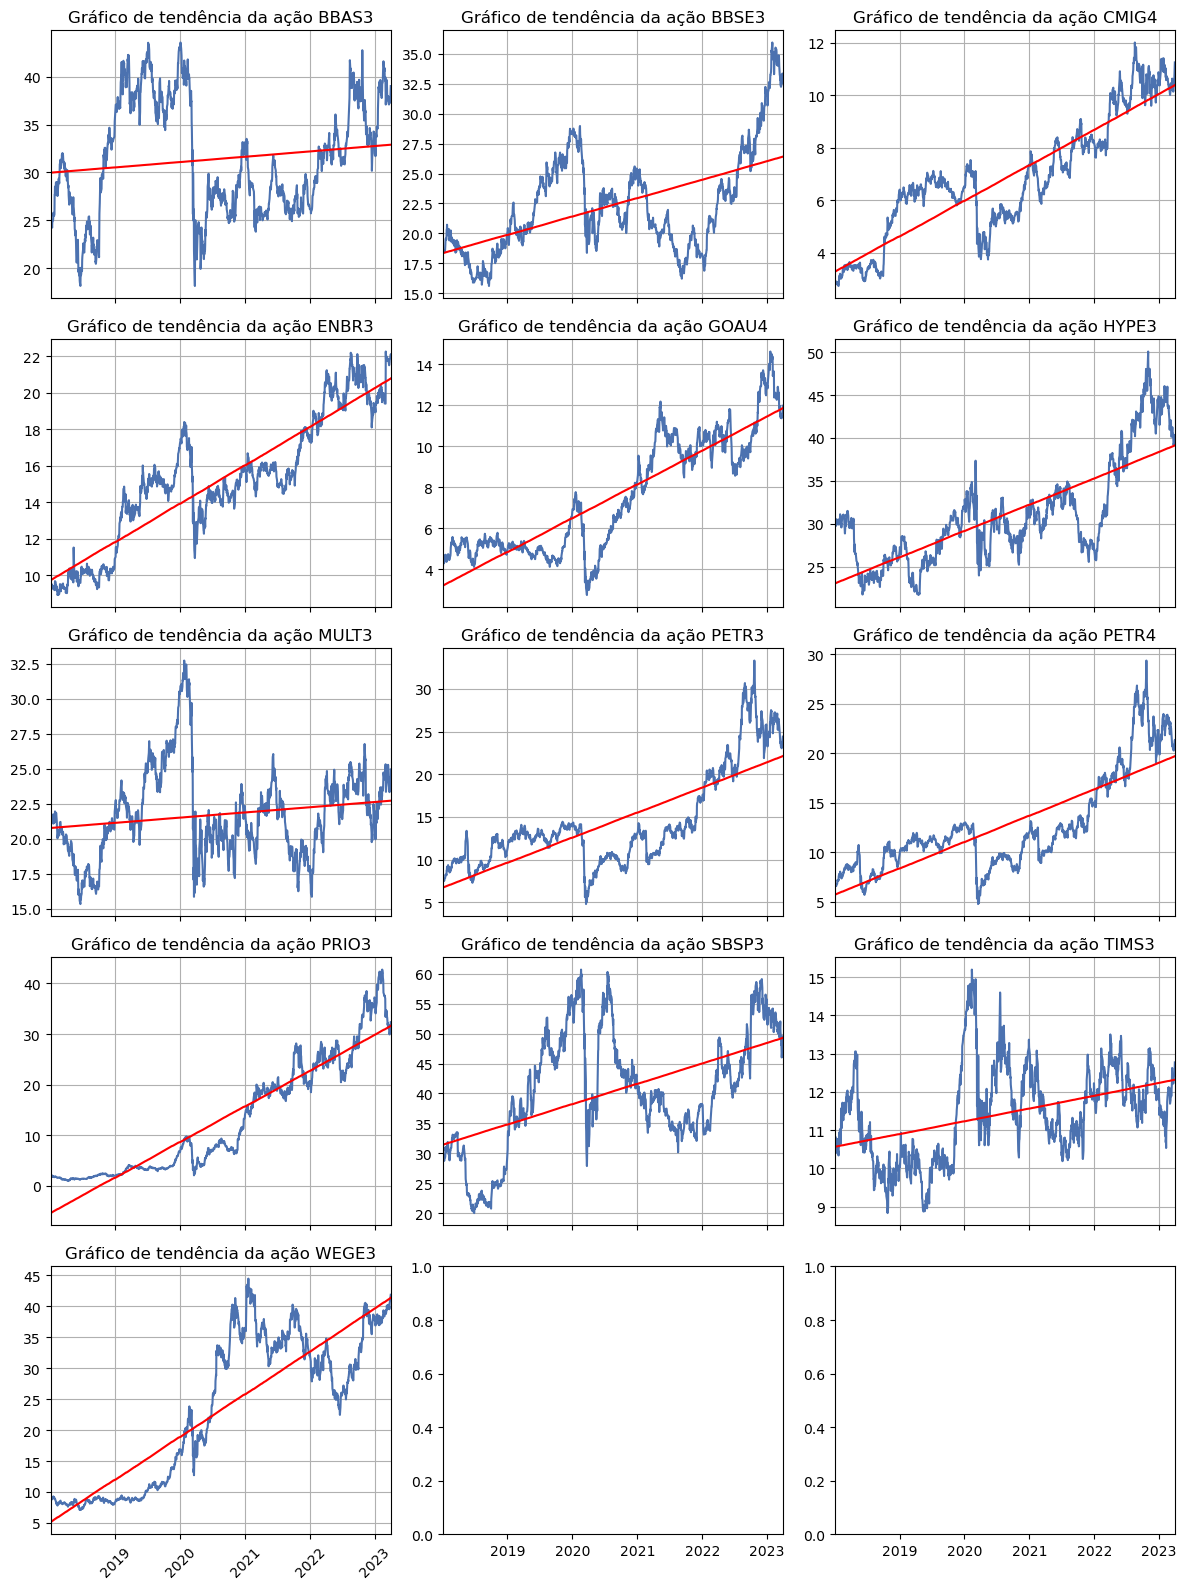

In [122]:
# Gráfico das ações que estão em tendência de alta
analysis_chart(dataset, (12,16))

In [44]:
# Base das ações em tendência de alta
dataset.head(10)

,BBAS3,BBSE3,CMIG4,ENBR3,GOAU4,HYPE3,MULT3,PETR3,PETR4,PRIO3,SBSP3,TIMS3,WEGE3
Date,,,,,,,,,,,,,
2018-01-02,23.987268,18.298756,2.898127,9.724759,4.122348,30.051554,21.355558,7.326260,6.493860,1.7090,29.925188,10.777552,8.906308
2018-01-03,24.293205,18.311502,2.873143,9.286460,4.108722,29.583427,21.441280,7.419265,6.552717,1.7400,29.388958,10.785718,8.771041
2018-01-04,24.526304,18.349760,2.839831,9.300158,4.258624,29.800779,21.417629,7.482678,6.564488,1.8002,28.818127,10.736730,8.685610
2018-01-05,24.526304,18.470903,2.843995,9.217977,4.272252,30.076628,21.574289,7.541862,6.603726,1.9016,29.146786,10.826540,8.721205
2018-01-08,24.584574,18.579290,2.852323,9.368643,4.326763,29.767334,21.305309,7.660233,6.682203,2.0456,29.743563,10.679573,8.792399
2018-01-09,24.351480,18.515533,2.794027,9.485064,4.319949,29.926161,21.367380,7.660233,6.682203,1.8286,29.337059,10.695905,8.934789
2018-01-10,24.249504,18.439024,2.835666,9.259068,4.333577,29.809124,21.255058,7.516500,6.591955,1.8040,28.748938,10.442796,8.863592
2018-01-11,24.803108,18.547413,2.893963,9.348096,4.551618,29.934513,21.521084,7.702507,6.768526,1.9800,29.129490,10.483620,9.034457
2018-01-12,24.861385,18.585667,2.864815,9.416580,4.667452,30.511303,21.423540,7.761693,6.788144,1.9180,29.302469,10.516279,9.102091


In [45]:
# Criando matriz de correlação da base
matriz_corr = analyze_correlation(dataset)

In [46]:
# Seleção de ações com baixa correlação
acoes_selecionadas = analyze_correlation_limit(dataset, correlation_limit=0.5)

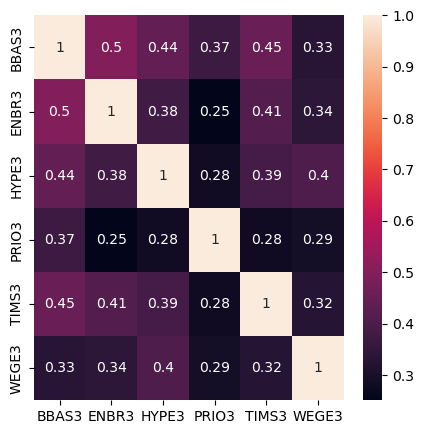

In [47]:
# Gerando grafico de correlação das ações selecionadas
matriz_corr = analyze_correlation(acoes_selecionadas)
heatmap_corr(matriz_corr, (5,5))

**Explorando a Base de Ações Selecionadas**

In [69]:
# Informações dos dados
acoes_selecionadas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1301 entries, 0 to 1300
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1301 non-null   object 
 1   BBAS3   1301 non-null   float64
 2   ENBR3   1301 non-null   float64
 3   HYPE3   1301 non-null   float64
 4   PRIO3   1301 non-null   float64
 5   TIMS3   1301 non-null   float64
 6   WEGE3   1301 non-null   float64
dtypes: float64(6), object(1)
memory usage: 71.3+ KB


In [70]:
# Dados estatísticos
acoes_selecionadas.describe()

,BBAS3,ENBR3,HYPE3,PRIO3,TIMS3,WEGE3
count,1301.000000,1301.000000,1301.000000,1301.000000,1301.000000,1301.000000
mean,31.437279,15.240037,31.071560,13.106681,11.439866,23.247702
std,5.942592,3.508151,6.050230,11.400803,1.204836,12.078878
min,18.166689,8.902948,21.677969,1.018600,8.828461,7.079747
25%,26.564987,13.427708,26.720079,3.280000,10.477455,9.073408
50%,30.885521,15.094038,29.926161,7.960000,11.462790,25.765629
75%,37.195415,17.838909,33.129829,22.090000,12.278606,34.395878
max,43.551609,22.248463,50.077835,42.750000,15.200933,44.467358


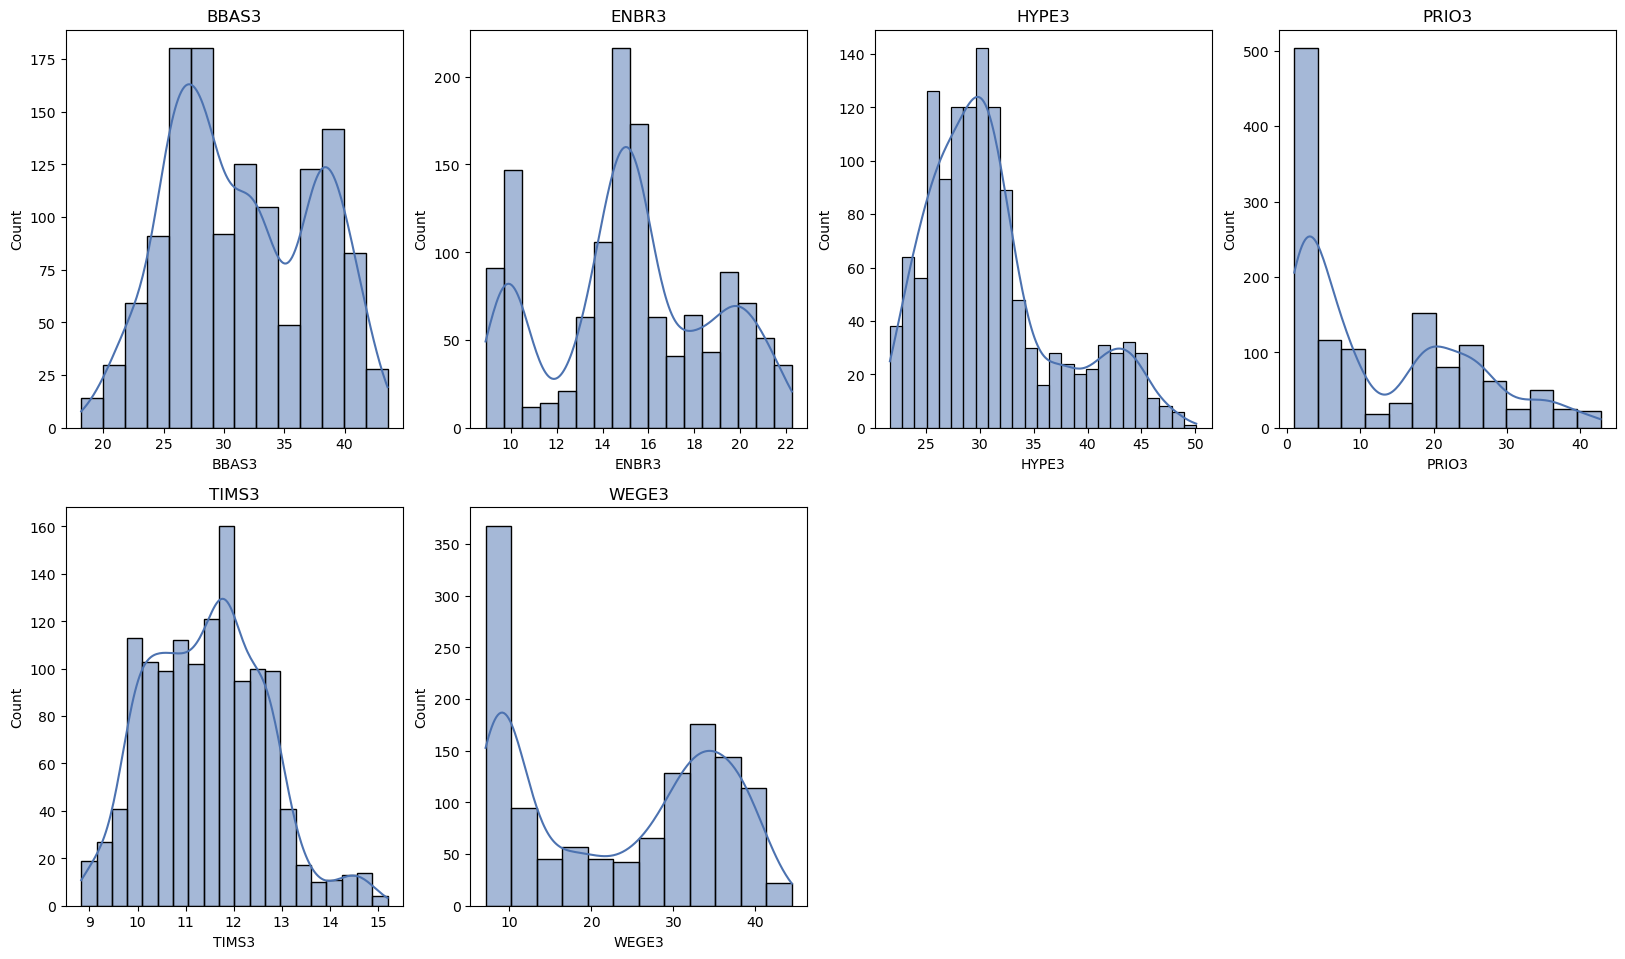

In [71]:
# Visualizando a distribuição da frequência de preços
chart_histogram_frequency(acoes_selecionadas)

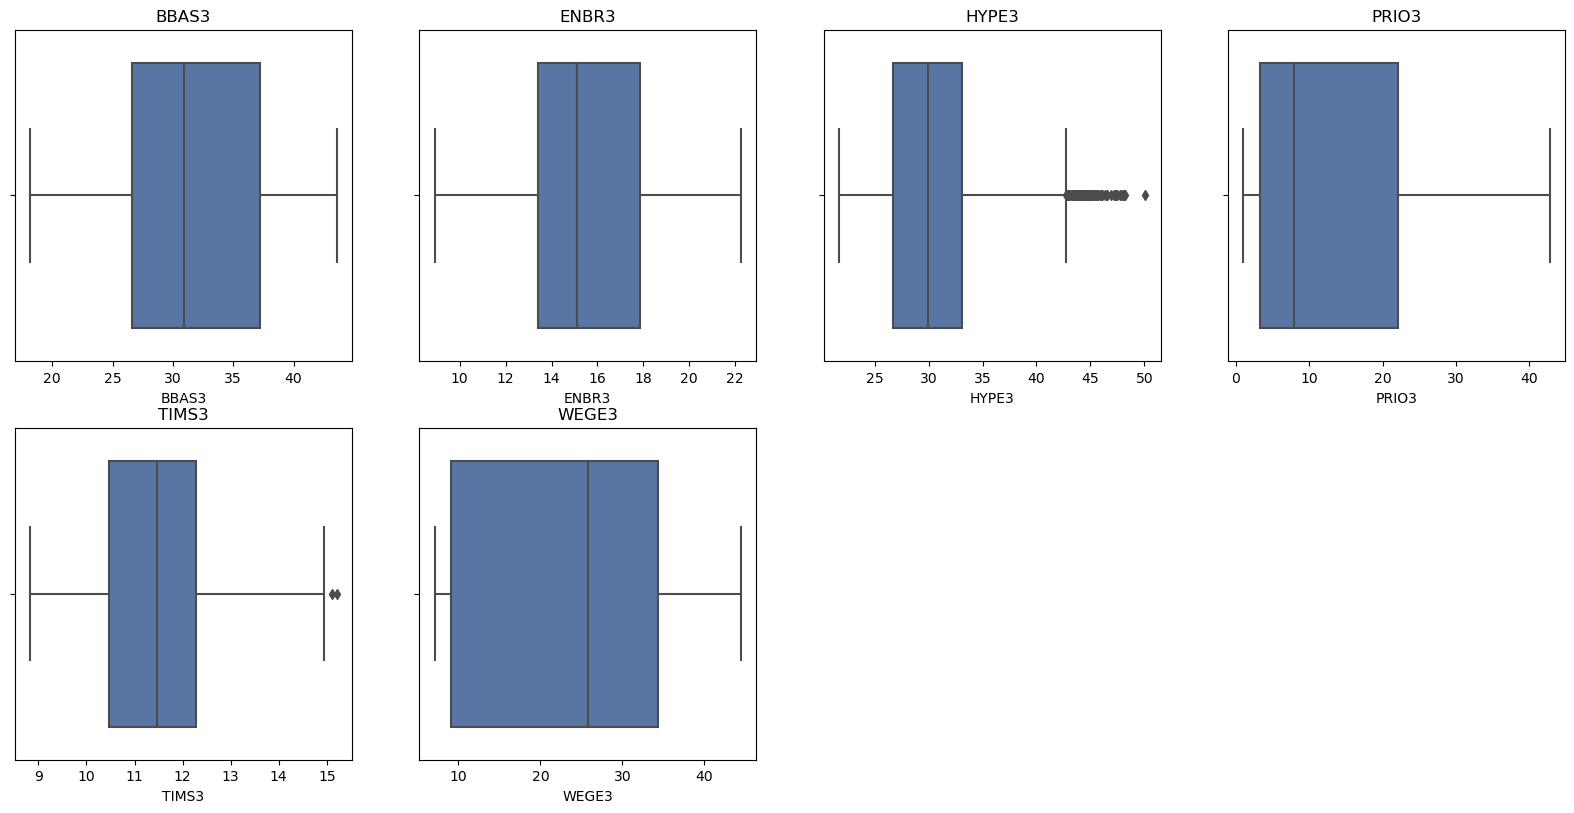

In [72]:
# Visualizando a distribuição dos preços
chart_boxplot_frequency(acoes_selecionadas)

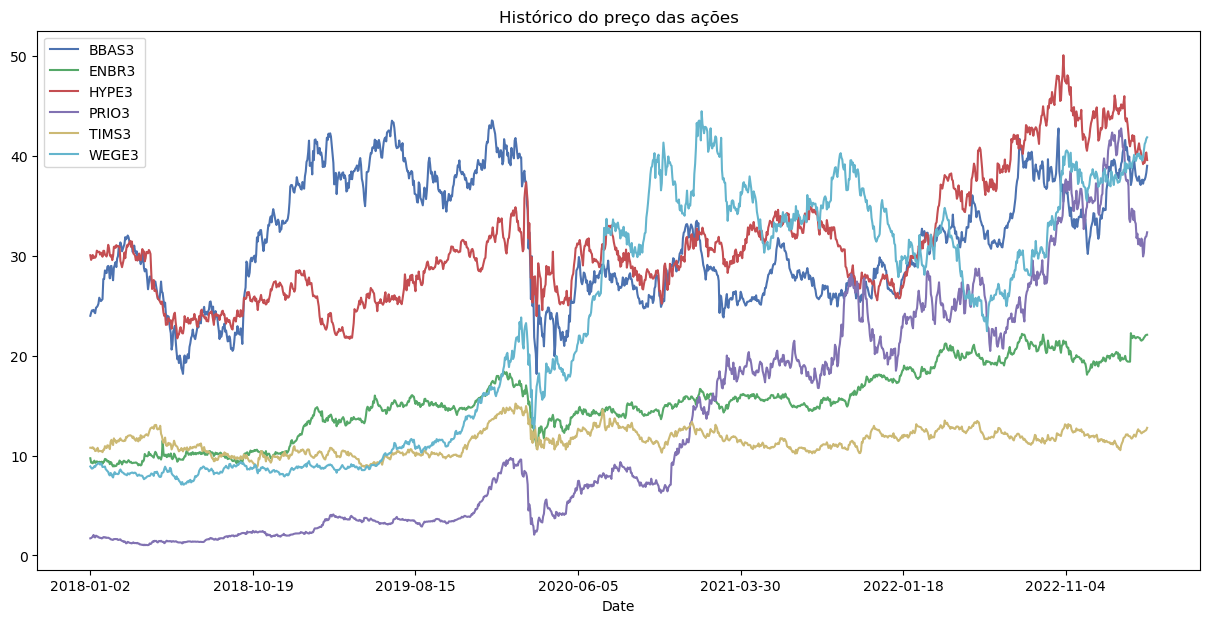

In [73]:
# Preço das ações do portfólio
chart_price_portfolio(acoes_selecionadas)

In [48]:
# Salvando base de dados do portfólio
acoes_selecionadas.to_csv('portfolio.csv')

## Análise financeira e otimização do portfólio

**Análise Financeira**

In [49]:
# Carregando a base de dados
portfolio = pd.read_csv('portfolio.csv', index_col='Date')
portfolio.head()

,BBAS3,ENBR3,HYPE3,PRIO3,TIMS3,WEGE3
Date,,,,,,
2018-01-02,23.987268,9.724759,30.051554,1.7090,10.777552,8.906308
2018-01-03,24.293205,9.286460,29.583427,1.7400,10.785718,8.771041
2018-01-04,24.526304,9.300158,29.800779,1.8002,10.736730,8.685610
2018-01-05,24.526304,9.217977,30.076628,1.9016,10.826540,8.721205
2018-01-08,24.584574,9.368643,29.767334,2.0456,10.679573,8.792399


In [50]:
# Analise financeira das ações
retorno_diario, retorno_log, retorno_anual, matriz_cov = analysis_finance(portfolio)

In [51]:
# Verificando a base dos retornos diários
retorno_diario

,BBAS3,ENBR3,HYPE3,PRIO3,TIMS3,WEGE3
Date,,,,,,
2018-01-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2018-01-03,0.012754,-0.045070,-0.015577,0.018139,0.000758,-0.015188
2018-01-04,0.009595,0.001475,0.007347,0.034598,-0.004542,-0.009740
2018-01-05,0.000000,-0.008837,0.009256,0.056327,0.008365,0.004098
2018-01-08,0.002376,0.016345,-0.010284,0.075726,-0.013575,0.008163
...,...,...,...,...,...,...
2023-03-24,0.010212,0.007309,0.005067,0.011694,0.000788,0.015543
2023-03-27,0.000532,0.004989,-0.001512,0.044254,0.007087,0.016786
2023-03-28,0.006913,0.005866,0.022974,0.008223,0.002346,0.004370


In [52]:
# Verificando a base dos retornos diários logarítmico 
retorno_log

,BBAS3,ENBR3,HYPE3,PRIO3,TIMS3,WEGE3
Date,,,,,,
2018-01-03,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2018-01-04,1.009549,1.001474,1.007320,1.034013,0.995448,0.990212
2018-01-05,1.009549,0.992585,1.016602,1.090674,1.003740,0.994262
2018-01-08,1.011945,1.008678,1.006093,1.170289,0.990021,1.002345
2018-01-09,1.002305,1.021135,1.011447,1.039052,0.991534,1.018448
...,...,...,...,...,...,...
2023-03-24,0.999495,1.877178,0.979689,4.863310,0.876595,3.170415
2023-03-27,1.000027,1.886520,0.978206,5.073903,0.882786,3.223191
2023-03-28,1.006917,1.897555,1.000425,5.115453,0.884854,3.237246


In [53]:
# Verificando a matriz de covâriancia
matriz_cov

,BBAS3,ENBR3,HYPE3,PRIO3,TIMS3,WEGE3
BBAS3,0.167244,0.060166,0.062447,0.101415,0.059535,0.051428
ENBR3,0.060166,0.087524,0.038763,0.049833,0.039210,0.037871
HYPE3,0.062447,0.038763,0.119292,0.066020,0.042981,0.052661
PRIO3,0.101415,0.049833,0.066020,0.451801,0.061013,0.073644
TIMS3,0.059535,0.039210,0.042981,0.061013,0.103242,0.039355
WEGE3,0.051428,0.037871,0.052661,0.073644,0.039355,0.143046


In [54]:
# Retorno anualizado em porcentagem
_retorno = pd.DataFrame(retorno_anual * 100)
_retorno = _retorno.reset_index()
_retorno = _retorno.rename(columns={'index':'Ações', 0:'Retorno Médio Anual'})
_retorno

,Ações,Retorno Médio Anual
0,BBAS3,17.804264
1,ENBR3,20.260129
2,HYPE3,11.282372
3,PRIO3,79.982091
4,TIMS3,8.465588
5,WEGE3,37.196659


In [55]:
# Volatilidade das ações em porcentagem
volatilidade_acoes = retorno_diario.std()
_volatilidade = pd.DataFrame(volatilidade_acoes * 100)
_volatilidade = _volatilidade.reset_index()
_volatilidade = _volatilidade.rename(columns={'index':'Ações', 0:'Volatilidade'})
_volatilidade

,Ações,Volatilidade
0,BBAS3,2.575179
1,ENBR3,1.862929
2,HYPE3,2.174899
3,PRIO3,4.232600
4,TIMS3,2.023300
5,WEGE3,2.381616


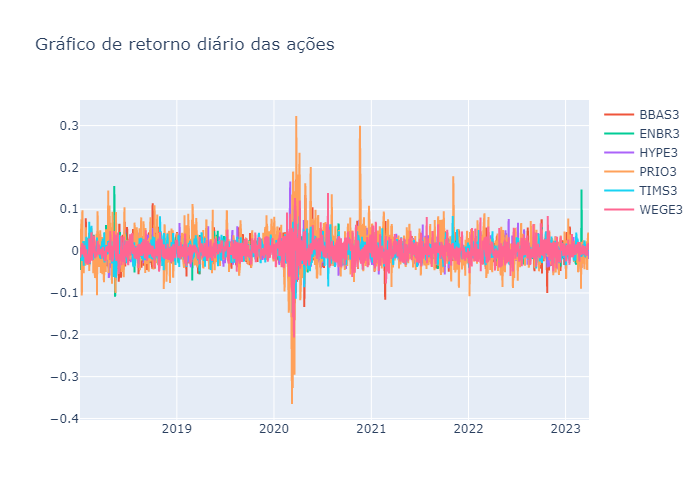

In [56]:
# Gráfico dos retornos diários
chart_return_daily(retorno_diario)

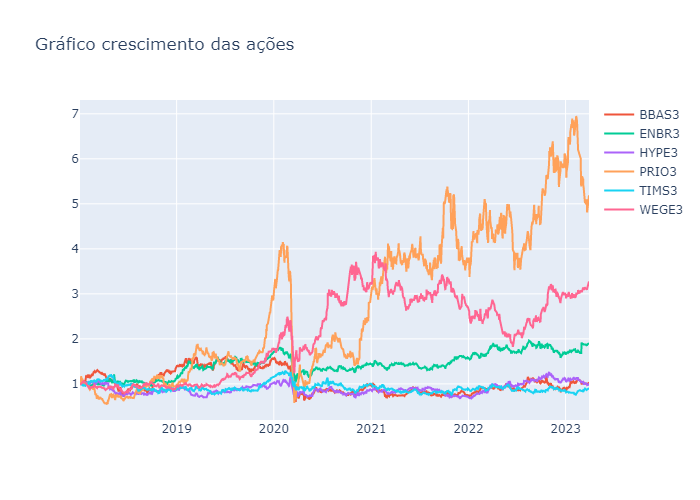

In [57]:
# Gráfico da evolução dos preços das ações
chart_return_log(retorno_log)

<Figure size 1000x1000 with 0 Axes>

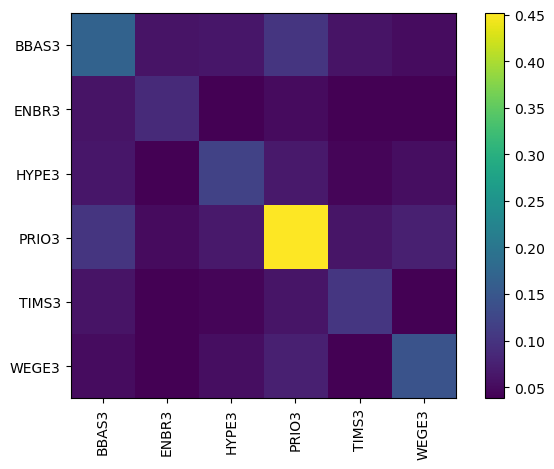

In [58]:
# Mapa de calor covariância
covariance_map(matriz_cov)

**Otimização do Portfólio**

In [59]:
# Otimização do portfolio
pesos, sharpe_ratio, acoes_pesos = portfolio_optimization(portfolio)

In [60]:
# Melhores pesos
pesos

array([0.06950496, 0.00893382, 0.00755276, 0.47172861, 0.01326789,
       0.42901195])

In [61]:
# Melhores indicadores
return_volatlity(portfolio, pesos)
print('Melhor sharpe ratio: {}'.format(sharpe_ratio))

Retorno esperado: 55.26%
Volatilidade esperada: 41.24%
Melhor sharpe ratio: 1.182


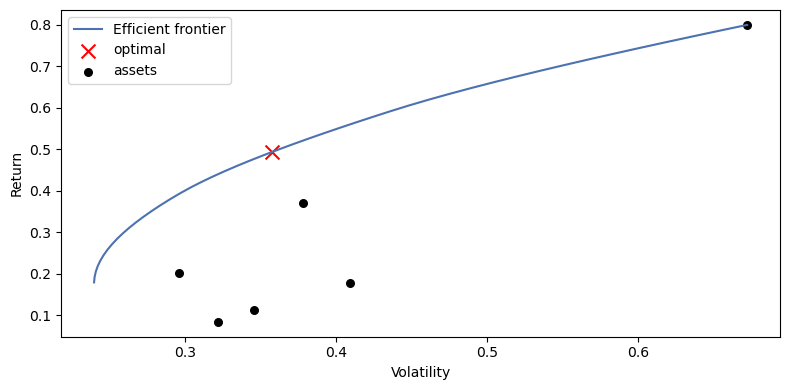

In [62]:
# Gráfico fronteira eficiente
chart_efficient_frontier(retorno_anual, matriz_cov)

In [63]:
# Vizualização da distribuição dos pesos por ação
acoes_pesos

,Ações,Pesos
0,BBAS3,0.069505
1,ENBR3,0.008934
2,HYPE3,0.007553
3,PRIO3,0.471729
4,TIMS3,0.013268
5,WEGE3,0.429012


Rendimento sobre capital investido: R$ 1010.48
Retorno total do portfólio: 1010.482%


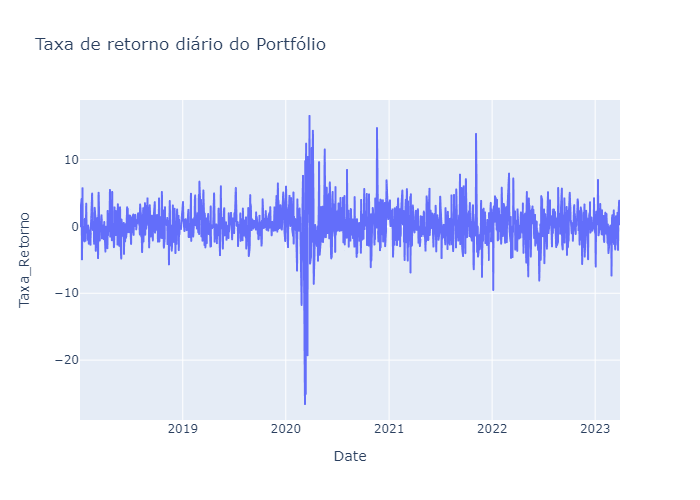

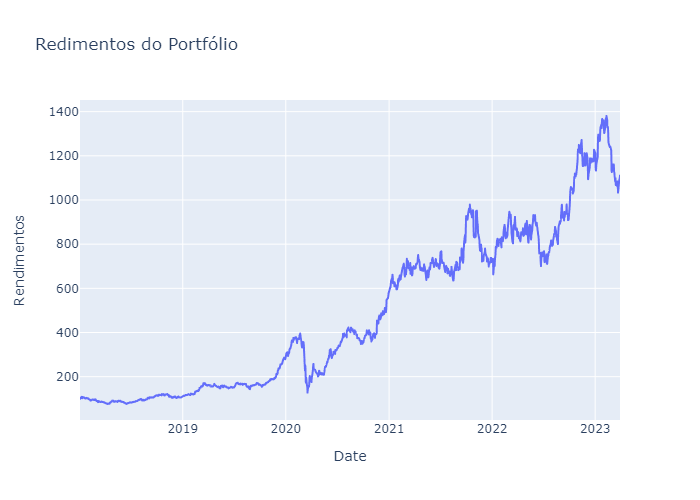

In [64]:
# Simulação de capital aplicado no portfólio
capital = 100
data_retorno = income_simulation(portfolio, pesos, capital)

### Previsão de Séries Temporais das Ações Usando o Algoritmo Prophet

**Visualizando a Base**

In [65]:
# Carregando base
df = pd.read_csv('portfolio.csv')

In [66]:
# Dimensões da base
show_dimensions(df)

Total Linhas: 1301
Total Colunas: 7


In [67]:
# Primeiras linhas de contações
df.head(10)

,Date,BBAS3,ENBR3,HYPE3,PRIO3,TIMS3,WEGE3
0,2018-01-02,23.987268,9.724759,30.051554,1.7090,10.777552,8.906308
1,2018-01-03,24.293205,9.286460,29.583427,1.7400,10.785718,8.771041
2,2018-01-04,24.526304,9.300158,29.800779,1.8002,10.736730,8.685610
3,2018-01-05,24.526304,9.217977,30.076628,1.9016,10.826540,8.721205
4,2018-01-08,24.584574,9.368643,29.767334,2.0456,10.679573,8.792399
5,2018-01-09,24.351480,9.485064,29.926161,1.8286,10.695905,8.934789
6,2018-01-10,24.249504,9.259068,29.809124,1.8040,10.442796,8.863592
7,2018-01-11,24.803108,9.348096,29.934513,1.9800,10.483620,9.034457
8,2018-01-12,24.861385,9.416580,30.511303,1.9180,10.516279,9.102091
9,2018-01-15,24.985218,9.348096,30.369198,1.9000,10.769389,9.162603


In [68]:
# Últimas linhas de cotações
df.tail(10)

,Date,BBAS3,ENBR3,HYPE3,PRIO3,TIMS3,WEGE3
1291,2023-03-17,37.299999,21.764372,40.679516,31.370001,12.460517,39.816765
1292,2023-03-20,37.090000,21.556902,40.500877,30.990000,12.343607,39.700001
1293,2023-03-21,37.529999,21.497627,40.024513,31.719999,12.216956,39.959999
1294,2023-03-22,37.619999,21.566782,39.716862,31.350000,12.275411,39.520000
1295,2023-03-23,37.209999,21.626059,39.171028,29.930000,12.363092,39.889999
1296,2023-03-24,37.590000,21.784128,39.369511,30.280001,12.372834,40.509998
1297,2023-03-27,37.610001,21.892803,39.309967,31.620001,12.460517,41.189999
1298,2023-03-28,37.869999,22.021236,40.213074,31.879999,12.489743,41.369999
1299,2023-03-29,38.310001,22.080513,40.342091,31.940001,12.567682,41.730000
1300,2023-03-30,39.009998,22.090393,39.580002,32.349998,12.772272,41.860001


### Treinamento do Modelo de Previsão

Parâmetros usados no treinamento do modelo:
> ```Python
> modelo = Prophet(growth='linear',
>            changepoints=None,
>            changepoint_prior_scale=0.05,
>            seasonality_mode='additive',
>            seasonality_prior_scale=10.0,
>            interval_width=0.8
>            )
>```

In [74]:
teste_bbas, modelo_bbas, previsao_bbas, previsao_bbas_teste = model_time_series(df, df.columns[1], 365)
teste_enbr, modelo_enbr, previsao_enbr, previsao_enbr_teste = model_time_series(df, df.columns[2], 365)
teste_hype, modelo_hype, previsao_hype, previsao_hype_teste = model_time_series(df, df.columns[3], 365)
teste_prio, modelo_prio, previsao_prio, previsao_prio_teste = model_time_series(df, df.columns[4], 365)
teste_tims, modelo_tims, previsao_tims, previsao_tims_teste = model_time_series(df, df.columns[5], 365)
teste_wege, modelo_wege, previsao_wege, previsao_wege_teste = model_time_series(df, df.columns[6], 365)

13:24:51 - cmdstanpy - INFO - Chain [1] start processing
13:24:52 - cmdstanpy - INFO - Chain [1] done processing
13:24:52 - cmdstanpy - INFO - Chain [1] start processing
13:24:53 - cmdstanpy - INFO - Chain [1] done processing
13:24:54 - cmdstanpy - INFO - Chain [1] start processing
13:24:54 - cmdstanpy - INFO - Chain [1] done processing
13:24:55 - cmdstanpy - INFO - Chain [1] start processing
13:24:55 - cmdstanpy - INFO - Chain [1] done processing
13:24:56 - cmdstanpy - INFO - Chain [1] start processing
13:24:56 - cmdstanpy - INFO - Chain [1] done processing
13:24:57 - cmdstanpy - INFO - Chain [1] start processing
13:24:57 - cmdstanpy - INFO - Chain [1] done processing


**Visualização dos Gráficos e Componentes das Séries Temporais Geradas**

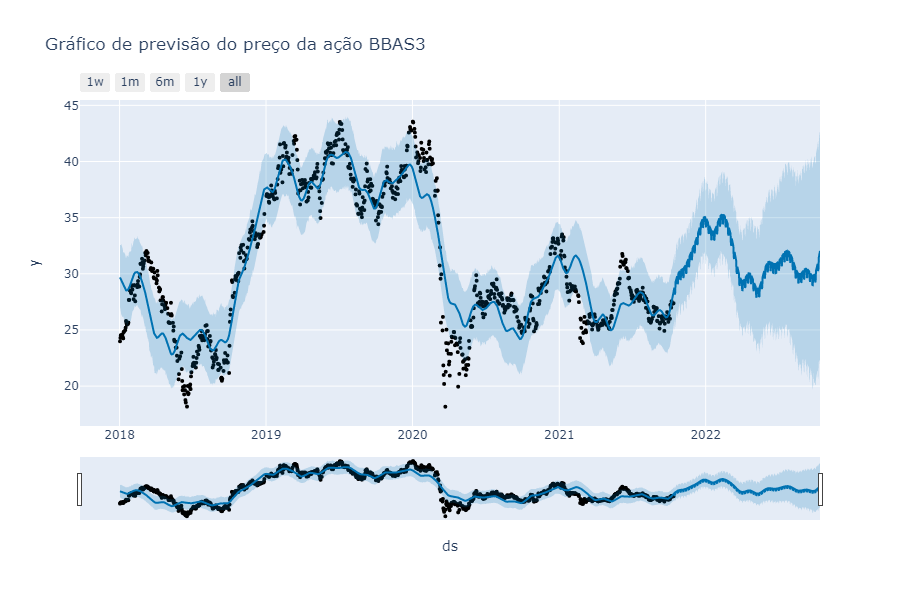

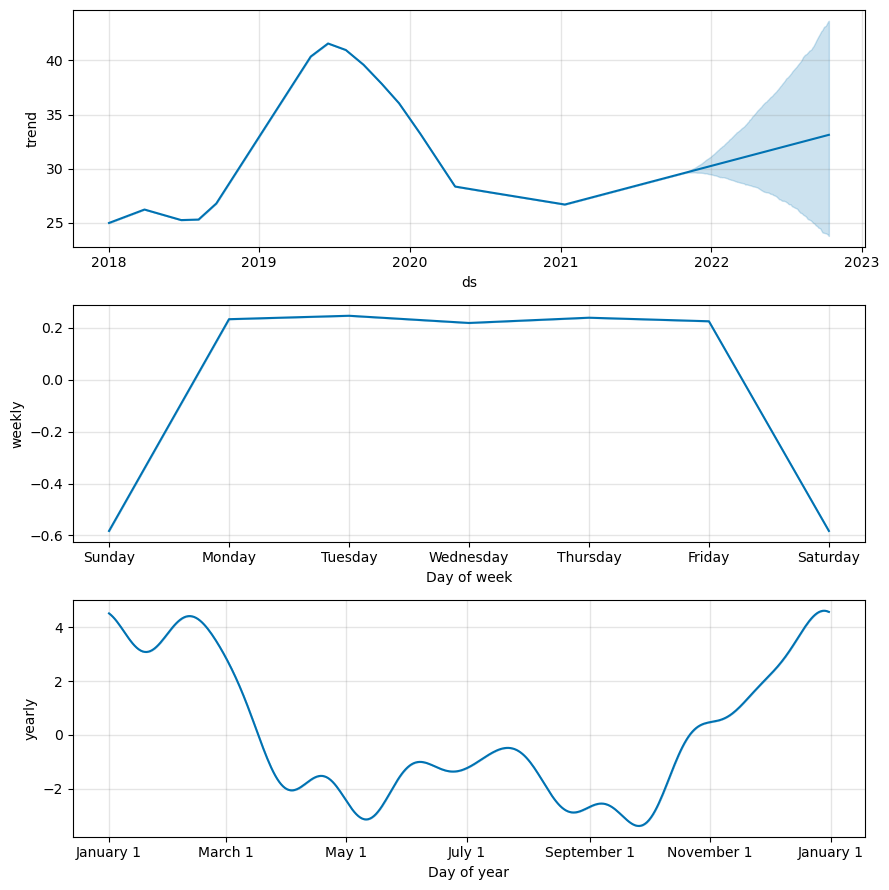

In [123]:
chart_forecast(modelo_bbas, previsao_bbas, df.columns[1])
fig_bbas_components = modelo_bbas.plot_components(previsao_bbas)

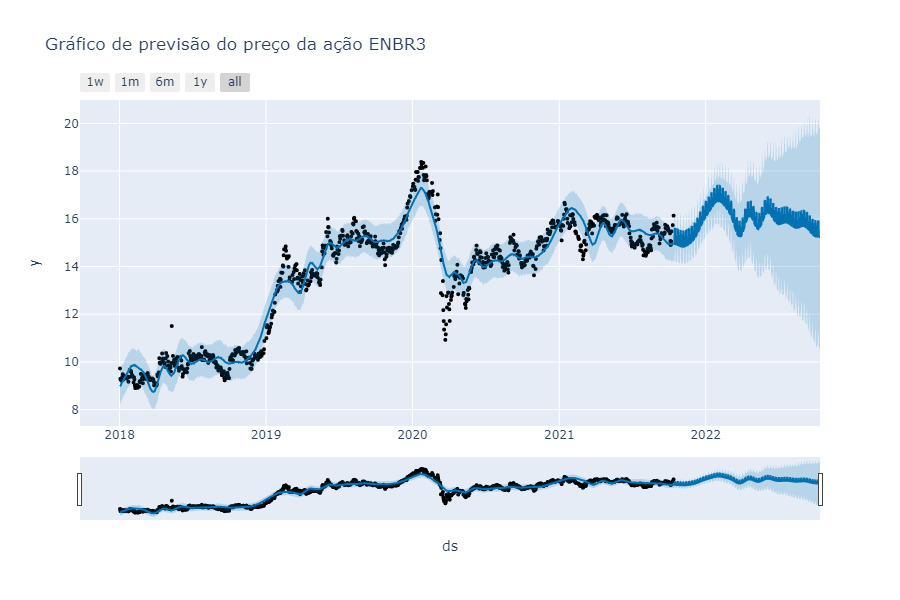

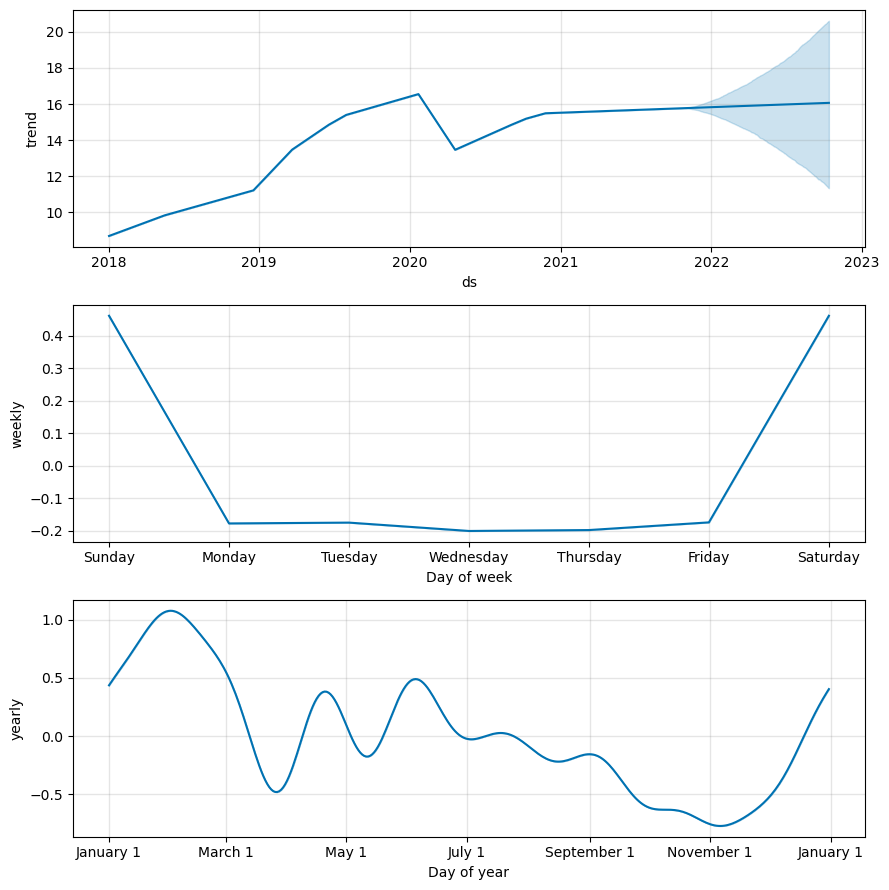

In [124]:
chart_forecast(modelo_enbr, previsao_enbr, df.columns[2])
fig_enbr_components = modelo_enbr.plot_components(previsao_enbr)

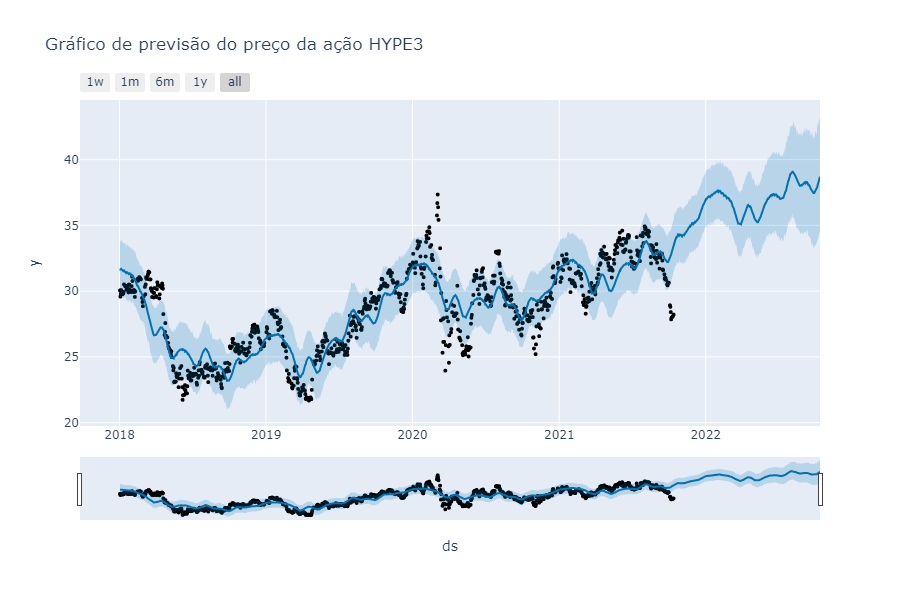

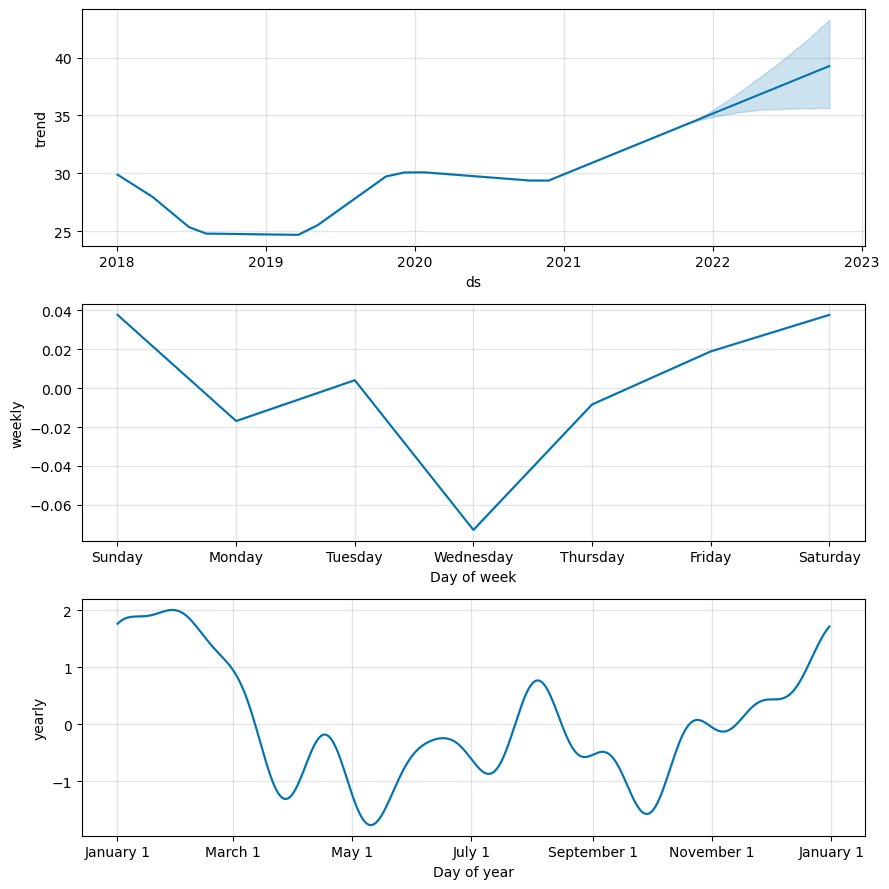

In [125]:
chart_forecast(modelo_hype, previsao_hype, df.columns[3])
fig_hype_components = modelo_hype.plot_components(previsao_hype)

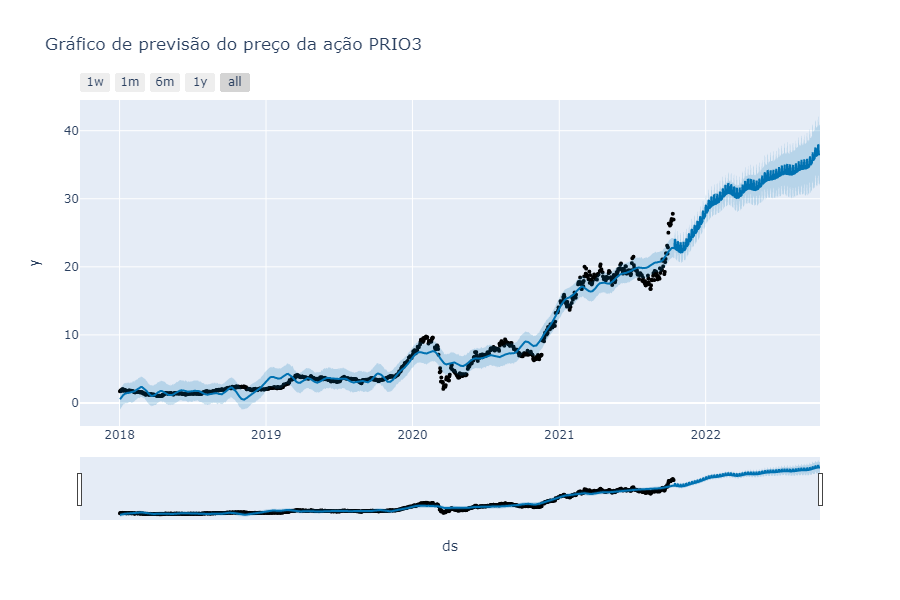

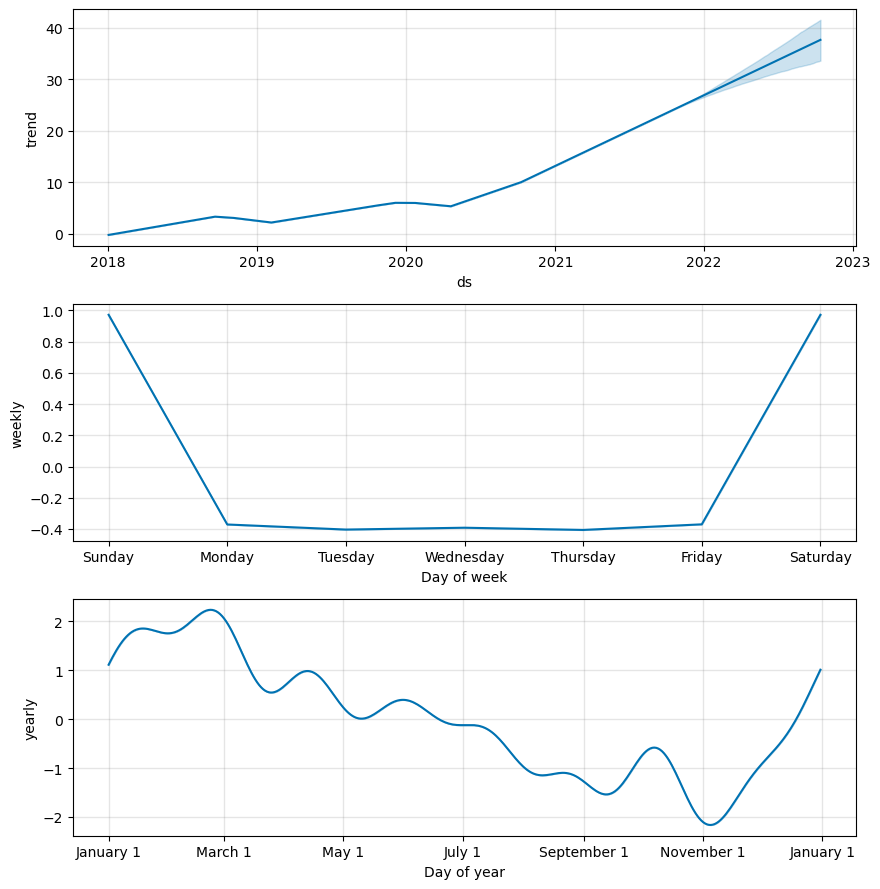

In [126]:
chart_forecast(modelo_prio, previsao_prio, df.columns[4])
fig_prio_components = modelo_prio.plot_components(previsao_prio)

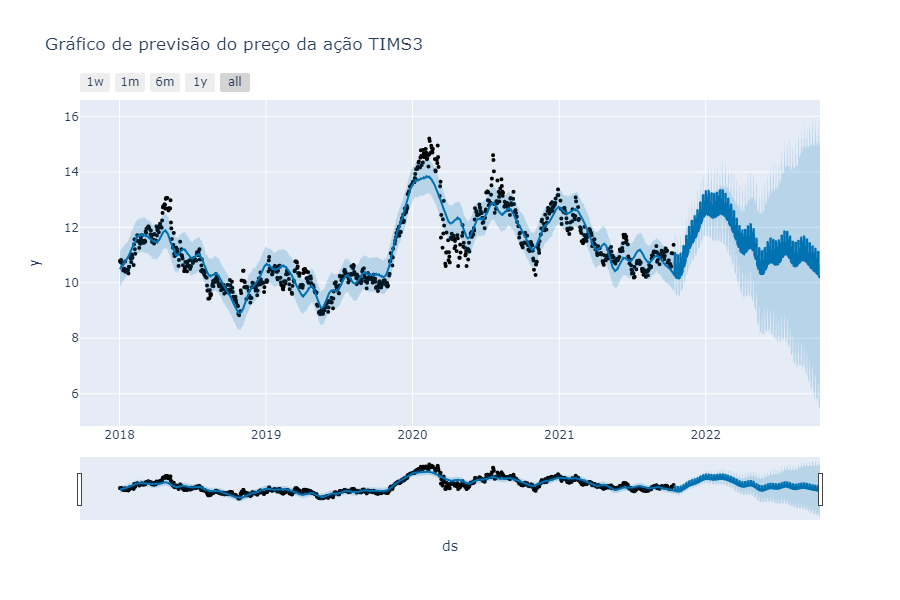

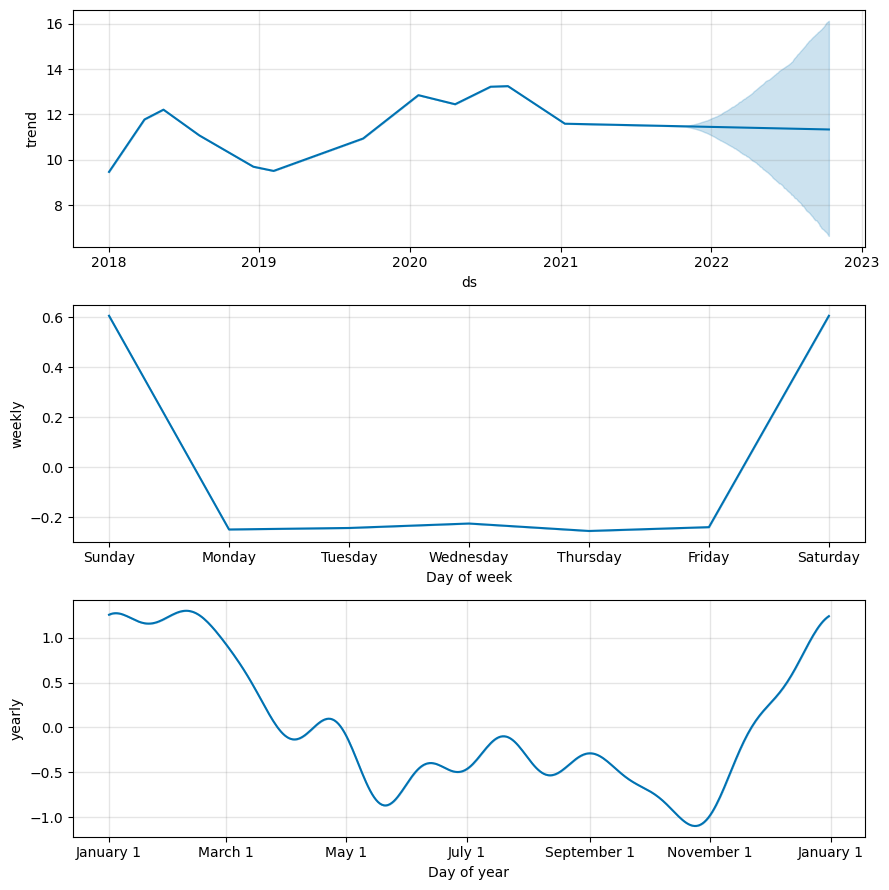

In [127]:
chart_forecast(modelo_tims, previsao_tims, df.columns[5])
fig_tims_components = modelo_tims.plot_components(previsao_tims)

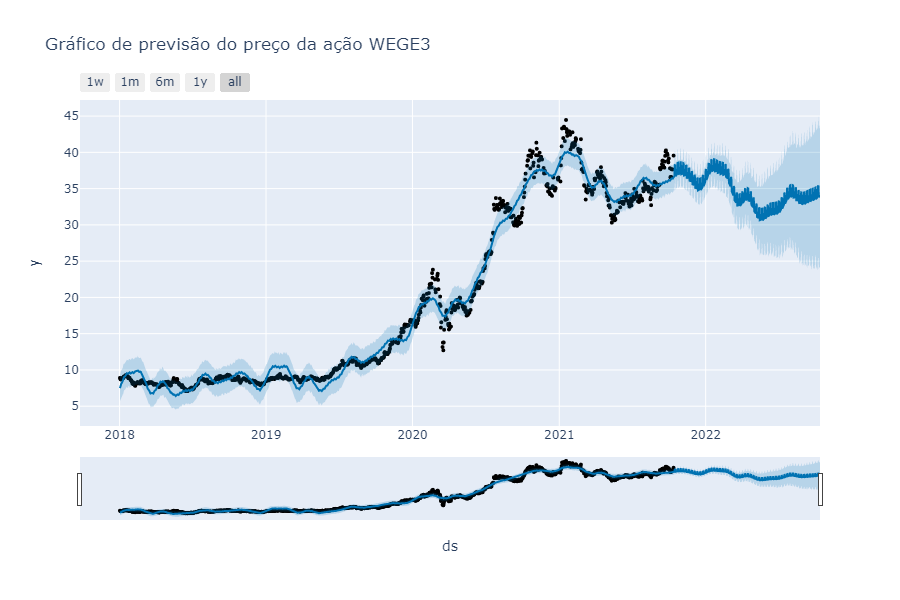

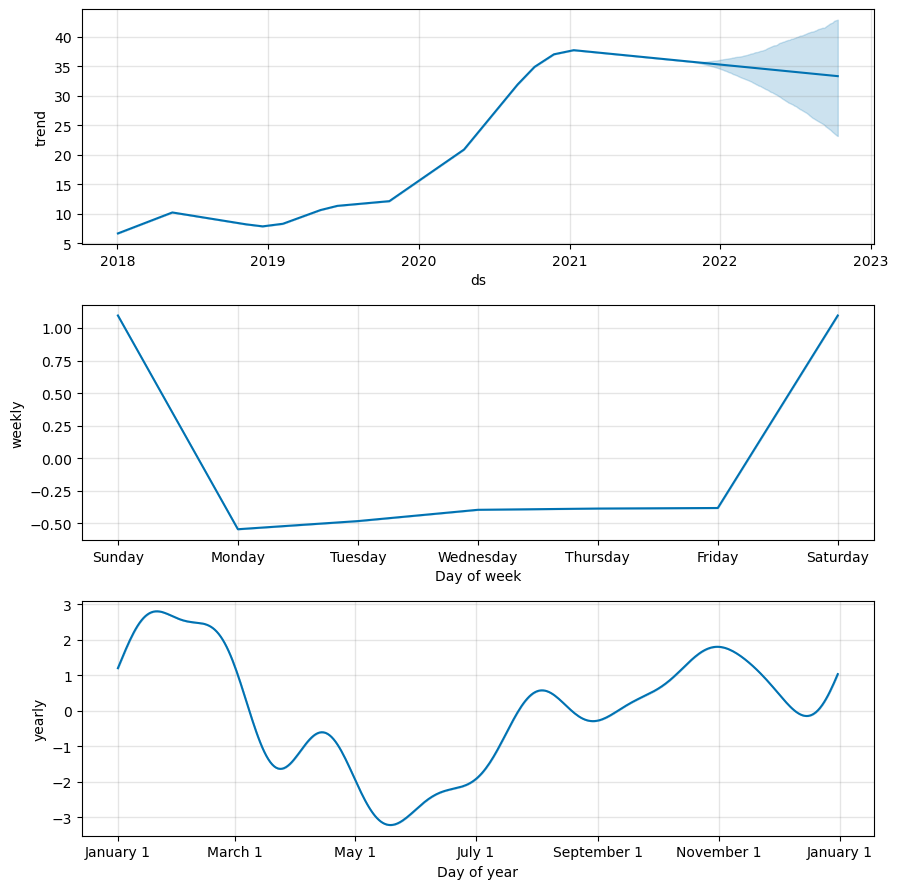

In [128]:
chart_forecast(modelo_wege, previsao_wege, df.columns[6])
fig_wege_components = modelo_wege.plot_components(previsao_wege)

### Avaliação das previsões

Análisando a margem de erro das previsões geradas pelo modelo usando a função `mean_absolute_error`.

In [77]:
mean_error_model_time_series(teste_bbas, previsao_bbas_teste)
mean_error_model_time_series(teste_enbr, previsao_enbr_teste)
mean_error_model_time_series(teste_hype, previsao_hype_teste)
mean_error_model_time_series(teste_prio, previsao_prio_teste) 
mean_error_model_time_series(teste_tims, previsao_tims_teste) 
mean_error_model_time_series(teste_wege, previsao_wege_teste) 

A margem de erro médio da previsão de preços da ação BBAS3 é de R$ 4.79
A margem de erro médio da previsão de preços da ação ENBR3 é de R$ 3.68
A margem de erro médio da previsão de preços da ação HYPE3 é de R$ 5.25
A margem de erro médio da previsão de preços da ação PRIO3 é de R$ 4.35
A margem de erro médio da previsão de preços da ação TIMS3 é de R$ 0.83
A margem de erro médio da previsão de preços da ação WEGE3 é de R$ 4.92


### Criando Base de Previsões de Cotações

A base iniciará em `31/03/2023` e irá até `29/03/2024`,serão gerados `261` previsões considerando apenas os dias úteis, pois a bolsa de valores funciona apenas de segunda a sexta.

In [100]:
# Criando base com as previsões
previsao_acoes = forecast_data(df, '2023-03-31', 330)

13:38:03 - cmdstanpy - INFO - Chain [1] start processing
13:38:03 - cmdstanpy - INFO - Chain [1] done processing
13:38:04 - cmdstanpy - INFO - Chain [1] start processing
13:38:04 - cmdstanpy - INFO - Chain [1] done processing
13:38:05 - cmdstanpy - INFO - Chain [1] start processing
13:38:06 - cmdstanpy - INFO - Chain [1] done processing
13:38:07 - cmdstanpy - INFO - Chain [1] start processing
13:38:07 - cmdstanpy - INFO - Chain [1] done processing
13:38:08 - cmdstanpy - INFO - Chain [1] start processing
13:38:08 - cmdstanpy - INFO - Chain [1] done processing
13:38:09 - cmdstanpy - INFO - Chain [1] start processing
13:38:10 - cmdstanpy - INFO - Chain [1] done processing


In [101]:
# Vsualizando dados
previsao_acoes

,Date,BBAS3,ENBR3,HYPE3,PRIO3,TIMS3,WEGE3
0,2023-03-31,37.587882,20.724329,44.690538,36.716387,11.811080,38.177330
1,2023-04-03,35.974828,21.120285,43.110744,37.531156,11.725456,39.000222
2,2023-04-04,35.987842,21.145350,43.272728,37.634283,11.716447,39.055751
3,2023-04-05,37.555029,20.781194,45.104641,36.980810,11.756043,38.186929
4,2023-04-06,37.563551,20.809393,45.206145,37.014127,11.746129,38.276646
...,...,...,...,...,...,...,...
256,2024-03-25,45.059075,21.234514,53.634128,46.227801,11.409989,45.399183
257,2024-03-26,45.045607,21.207451,53.692729,46.303735,11.428740,45.554128
258,2024-03-27,45.111527,21.230757,53.798436,46.366198,11.422554,45.609485
259,2024-03-28,45.163813,21.246220,53.923640,46.485256,11.438249,45.628973


In [102]:
# Dimensões da base
show_dimensions(previsao_acoes)

Total Linhas: 261
Total Colunas: 7


## Analise Exploratória e Financeira da base de Previsão

**Explorando a base de dados**

In [103]:
# Base de dados
data = previsao_acoes

In [104]:
# Informações da base
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261 entries, 0 to 260
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    261 non-null    datetime64[ns]
 1   BBAS3   261 non-null    float64       
 2   ENBR3   261 non-null    float64       
 3   HYPE3   261 non-null    float64       
 4   PRIO3   261 non-null    float64       
 5   TIMS3   261 non-null    float64       
 6   WEGE3   261 non-null    float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 14.4 KB


In [105]:
# Informações estatística da base
data.describe()

,BBAS3,ENBR3,HYPE3,PRIO3,TIMS3,WEGE3
count,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000
mean,40.390284,21.338250,49.954426,41.571148,11.194214,41.172576
std,2.215859,0.252587,3.099731,2.994528,0.398953,3.449880
min,35.877725,20.724329,43.110744,36.716387,10.359233,36.050565
25%,38.672182,21.157129,47.030880,39.098342,10.969441,38.106877
50%,40.498989,21.293322,50.658990,40.499151,11.265090,41.201329
75%,41.491636,21.512164,52.359817,44.940947,11.449007,44.501549
max,45.163813,21.927553,54.132177,47.249774,11.871516,47.330355


In [106]:
# Visualizando primeiras linhas
data.head(10)

,Date,BBAS3,ENBR3,HYPE3,PRIO3,TIMS3,WEGE3
0,2023-03-31,37.587882,20.724329,44.690538,36.716387,11.811080,38.177330
1,2023-04-03,35.974828,21.120285,43.110744,37.531156,11.725456,39.000222
2,2023-04-04,35.987842,21.145350,43.272728,37.634283,11.716447,39.055751
3,2023-04-05,37.555029,20.781194,45.104641,36.980810,11.756043,38.186929
4,2023-04-06,37.563551,20.809393,45.206145,37.014127,11.746129,38.276646
5,2023-04-07,37.576297,20.816373,45.381478,37.150642,11.763779,38.449921
6,2023-04-10,37.677085,20.874936,45.596544,37.270805,11.757448,38.517592
7,2023-04-11,37.770808,20.926169,45.822322,37.443492,11.773858,38.542684
8,2023-04-12,36.199233,21.333308,44.233201,38.256420,11.701035,39.350059
9,2023-04-13,36.246536,21.366271,44.370194,38.348583,11.705143,39.382608


In [107]:
# Visualizando últimas linhas
data.tail(10)

,Date,BBAS3,ENBR3,HYPE3,PRIO3,TIMS3,WEGE3
251,2024-03-18,44.975901,21.244316,53.537938,46.068427,11.448168,45.424259
252,2024-03-19,45.064743,21.261617,53.627803,46.176783,11.459391,45.419347
253,2024-03-20,43.478129,21.634131,51.917614,46.931644,11.379463,46.206822
254,2024-03-21,43.502090,21.632395,51.950143,46.972880,11.374902,46.230182
255,2024-03-22,45.066141,21.238497,53.655211,46.256729,11.417759,45.333108
256,2024-03-25,45.059075,21.234514,53.634128,46.227801,11.409989,45.399183
257,2024-03-26,45.045607,21.207451,53.692729,46.303735,11.428740,45.554128
258,2024-03-27,45.111527,21.230757,53.798436,46.366198,11.422554,45.609485
259,2024-03-28,45.163813,21.246220,53.923640,46.485256,11.438249,45.628973
260,2024-03-29,43.546376,21.617818,52.244009,47.249774,11.363960,46.438125


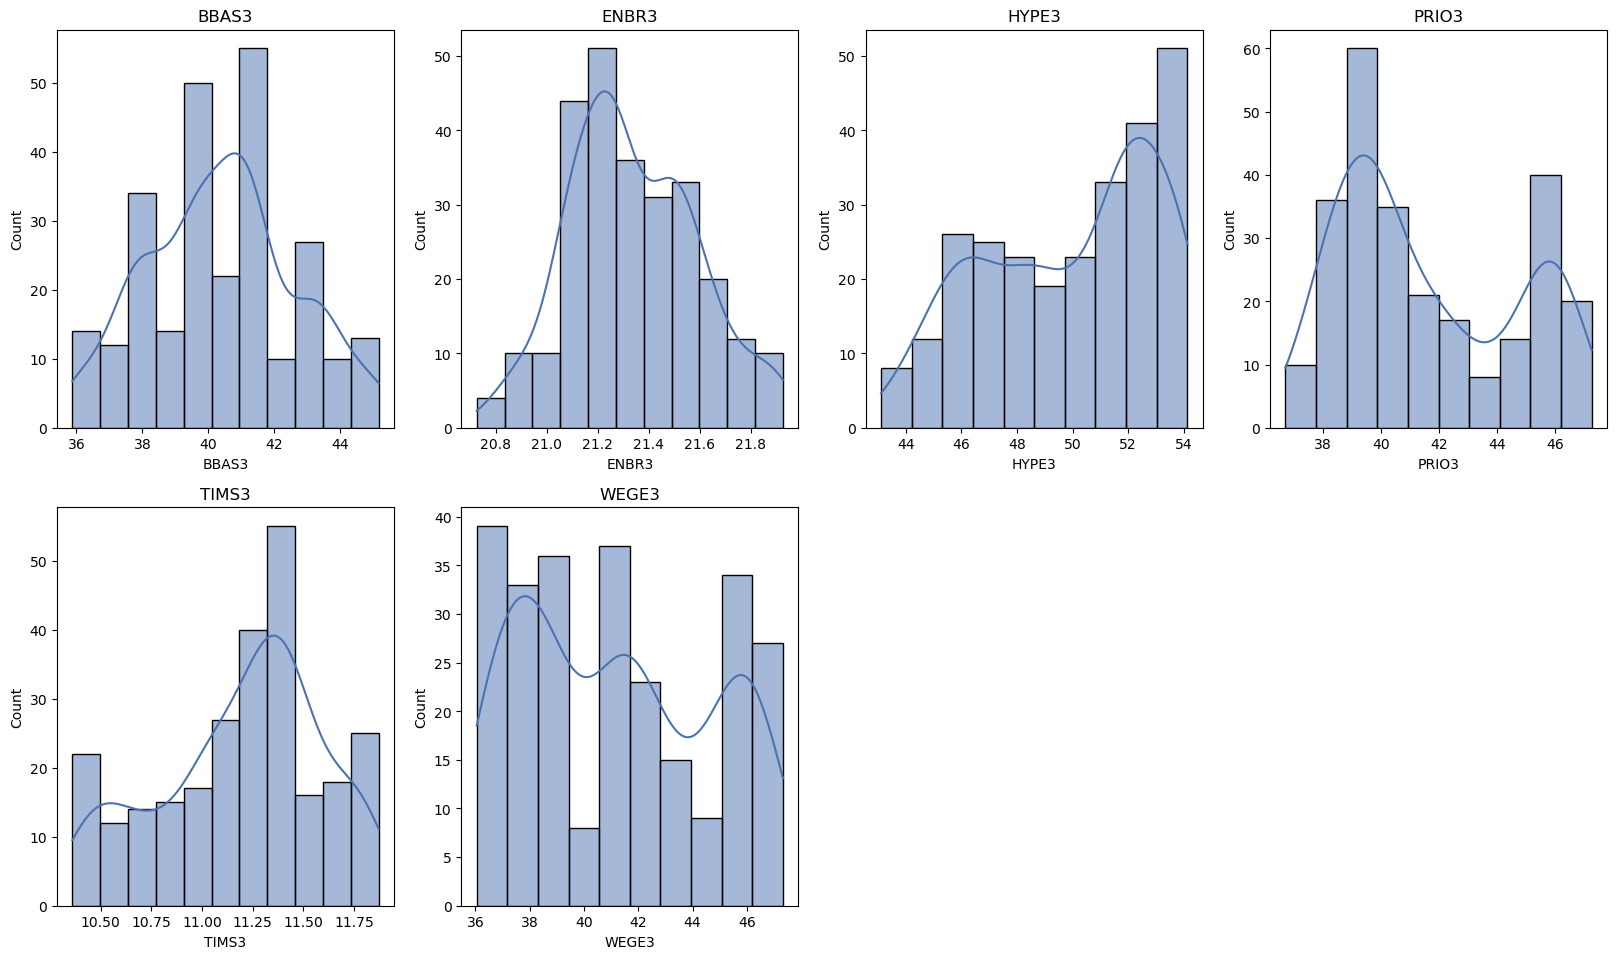

In [108]:
# Visualizando a distribuição das frequência dos preços
chart_histogram_frequency(data)

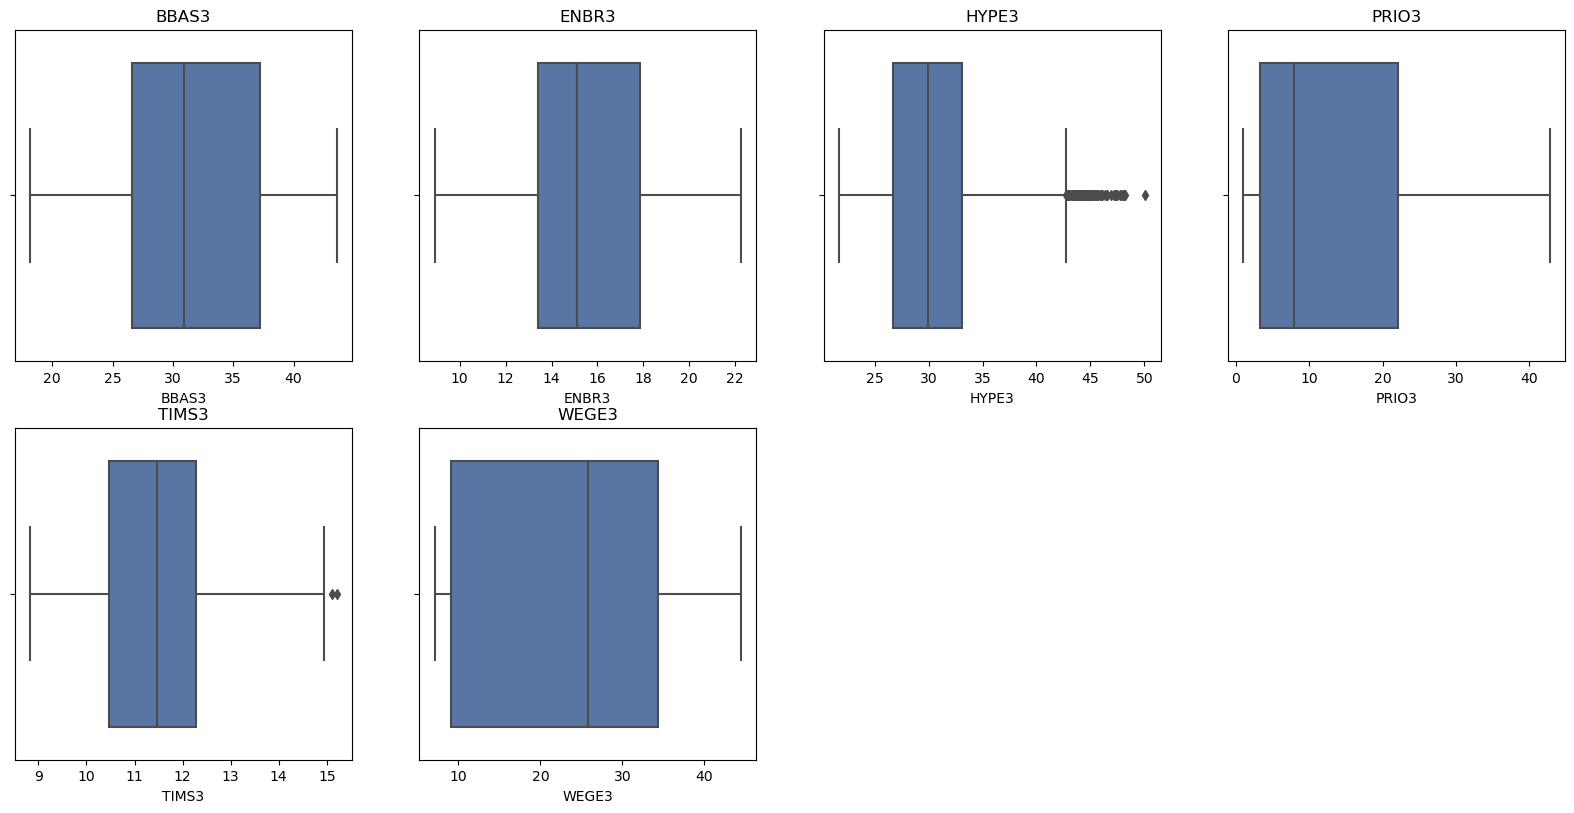

In [109]:
# Visualizando a distribuição dos preços
chart_boxplot_frequency(data)

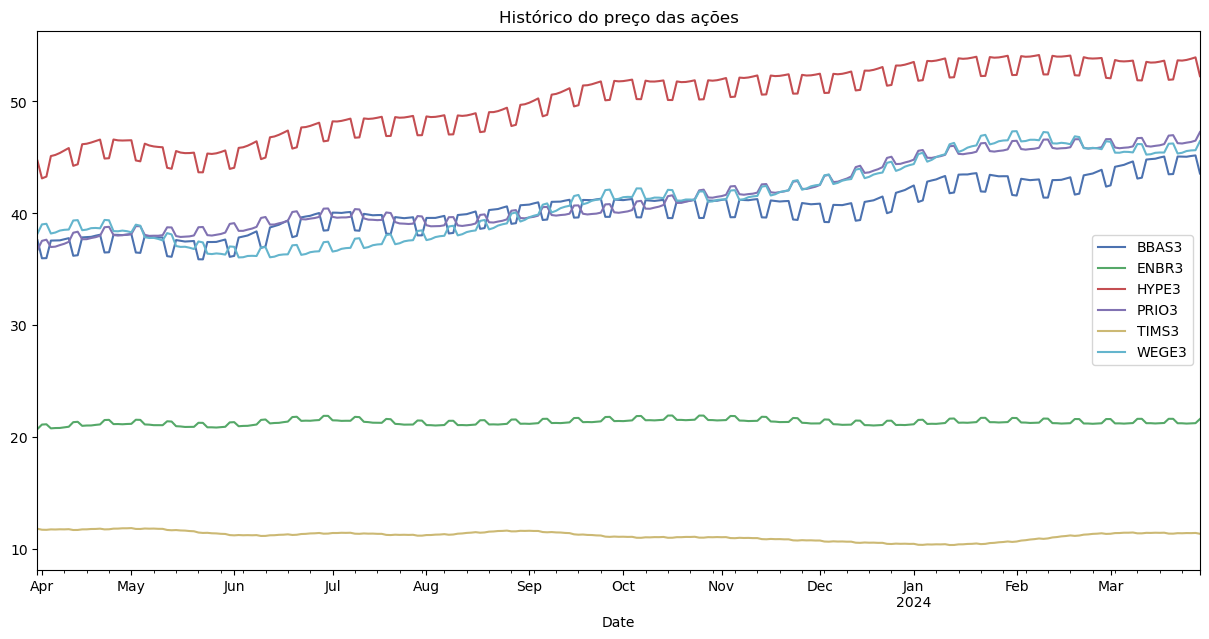

In [110]:
# Preço das ações do portfólio
chart_price_portfolio(data)

**Análise Financeira**

In [111]:
# Definindo Date como índice
data = data.set_index('Date')

In [112]:
# Análise financeira das ações
retorno_diario, retorno_log, retorno_anual, matriz_cov = analysis_finance(data)

In [113]:
# Verificando a base dos retornos diários
retorno_diario

,BBAS3,ENBR3,HYPE3,PRIO3,TIMS3,WEGE3
Date,,,,,,
2023-03-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2023-04-03,-0.042914,0.019106,-0.035350,0.022191,-0.007249,0.021554
2023-04-04,0.000362,0.001187,0.003757,0.002748,-0.000768,0.001424
2023-04-05,0.043548,-0.017222,0.042334,-0.017364,0.003380,-0.022246
2023-04-06,0.000227,0.001357,0.002250,0.000901,-0.000843,0.002349
...,...,...,...,...,...,...
2024-03-25,-0.000157,-0.000188,-0.000393,-0.000625,-0.000681,0.001458
2024-03-26,-0.000299,-0.001274,0.001093,0.001643,0.001643,0.003413
2024-03-27,0.001463,0.001099,0.001969,0.001349,-0.000541,0.001215


In [114]:
# Verificando a base dos retornos diários logaritimico
retorno_log

,BBAS3,ENBR3,HYPE3,PRIO3,TIMS3,WEGE3
Date,,,,,,
2023-04-03,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2023-04-04,1.000362,1.001186,1.003750,1.002744,0.999231,1.001423
2023-04-05,1.043003,0.983794,1.045368,0.985180,1.002603,0.978894
2023-04-06,1.043240,0.985128,1.047718,0.986067,1.001757,0.981191
2023-04-07,1.043594,0.985458,1.051774,0.989697,1.003261,0.985623
...,...,...,...,...,...,...
2024-03-25,1.182126,0.993626,1.190736,1.217175,0.971528,1.145152
2024-03-26,1.181773,0.992359,1.192036,1.219173,0.973123,1.149054
2024-03-27,1.183501,0.993449,1.194381,1.220817,0.972596,1.150450


In [115]:
# Verificando a matriz de covâriancia
matriz_cov

,BBAS3,ENBR3,HYPE3,PRIO3,TIMS3,WEGE3
BBAS3,0.115480,-0.051353,0.100236,-0.051281,0.015910,-0.059685
ENBR3,-0.051353,0.023538,-0.044661,0.023306,-0.007109,0.026796
HYPE3,0.100236,-0.044661,0.087451,-0.044486,0.013773,-0.051740
PRIO3,-0.051281,0.023306,-0.044486,0.023635,-0.006922,0.026965
TIMS3,0.015910,-0.007109,0.013773,-0.006922,0.003216,-0.007926
WEGE3,-0.059685,0.026796,-0.051740,0.026965,-0.007926,0.032285


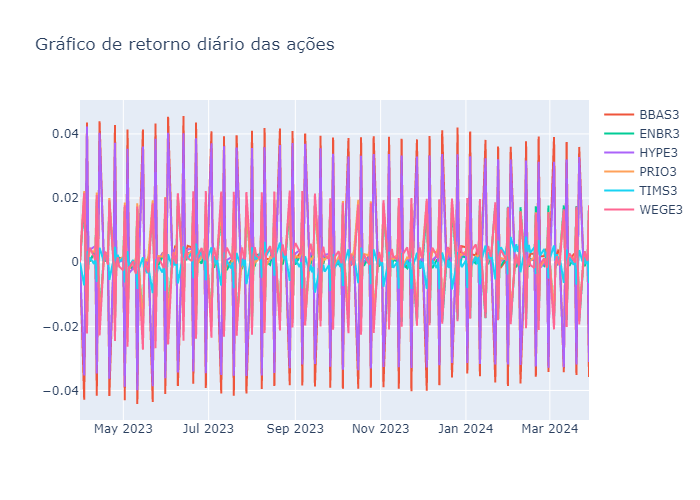

In [116]:
# Gráfico dos retornos diários
chart_return_daily(retorno_diario)

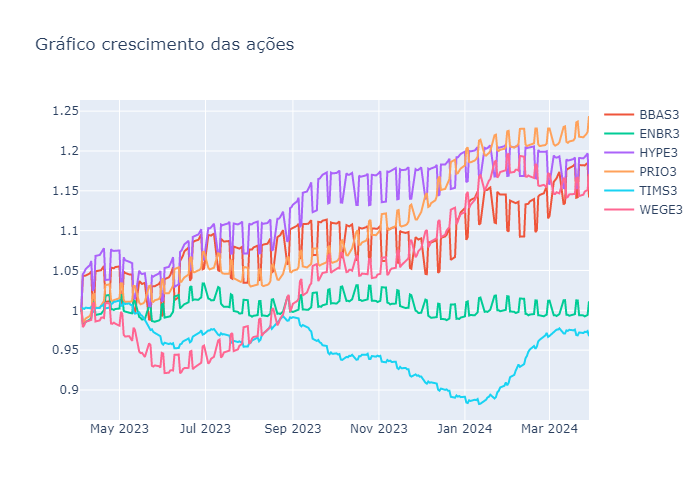

In [117]:
# Gráfico da evolução dos preços das ações
chart_return_log(retorno_log)

In [118]:
# Pesos otimizados do portfólio
pesos

array([0.06950496, 0.00893382, 0.00755276, 0.47172861, 0.01326789,
       0.42901195])

In [129]:
# Indicadores
indication_forecast(data, pesos)

Retorno esperado: 22.38%
Volatilidade esperada: 12.39%
Sharpe Ratio: 1.806


Rendimento sobre capital investido: R$ 24.03
Retorno total do portfólio: 24.034%


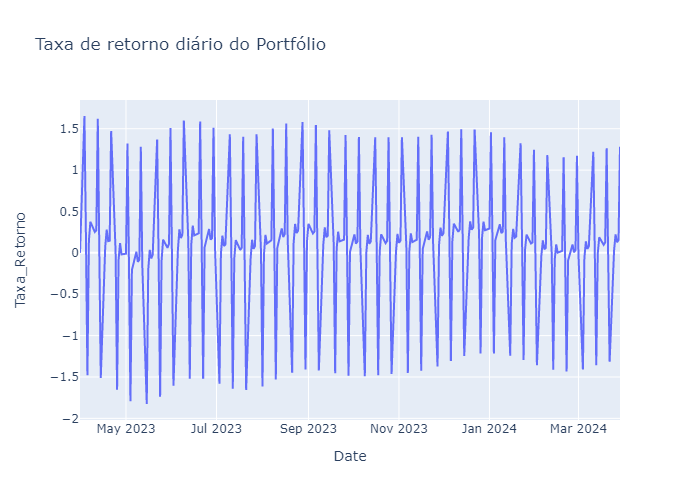

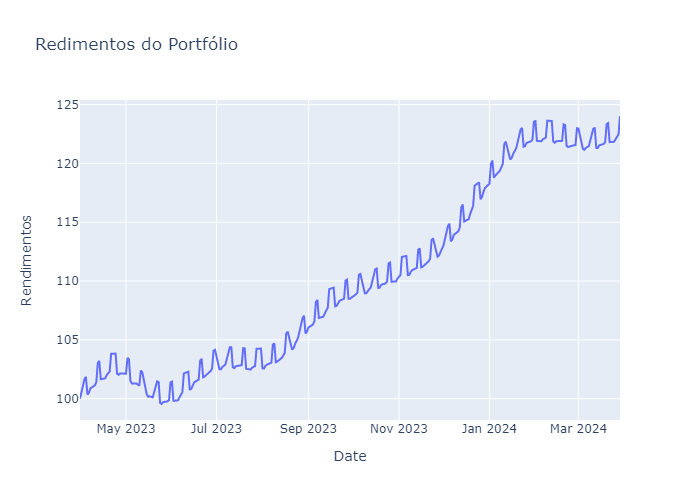

In [130]:
# Simulação de rendimentos da base de prevista
capital = 100
data_rend = income_simulation(data, pesos, capital)